In [1]:
import csv
import pandas as pds
from IPython.display import display
import json
import requests

def get_online_csv(url):
  """
  Cette fonction permet de récupérer le contenu d'un csv en ligne.
  Pour les google spreadsheets: fichier > publier sur le web > format csv > copier le lien
  """
  results = []
  with requests.Session() as s:
      download = s.get(url)
      decoded_content = download.content.decode('utf-8')
      reader = csv.DictReader(decoded_content.splitlines(), delimiter=',')
      for row in reader:
        results.append(dict(row))
  return results


def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    display(bundle, raw=True)

# 1. Stabilisation des données Navigo

Il s'agit d'abord de s'assurer qu'on dispose de données stables pour effectuer la projection des prix par tonneau par partenaire.

## 1.1. Analyse de Christine sorti à partir de la base postgresql durant le visusprint

Note : en relation à une première stratégie d'estimation "fine" finalement abandonnée, cette extraction présentait un compte par pays et par produit, nous avions donc des tonnages qui n'incluent pas les bateaux sans cargaison définie.

Agrégation des valeurs par pays à partir de l'extraction de Christine:
                     pays   tonnage
0              Angleterre  181112.0
1                Danemark   47201.0
2                 Espagne   48398.0
3     Etats de l'Empereur   42778.0
4   États-Unis d'Amérique   56971.0
5                Hollande  103274.0
6                Portugal   26846.0
7                  Prusse   25539.0
8     Villes hanséatiques  120050.0
9                  Russie   21135.0
10                  Suède   17515.0


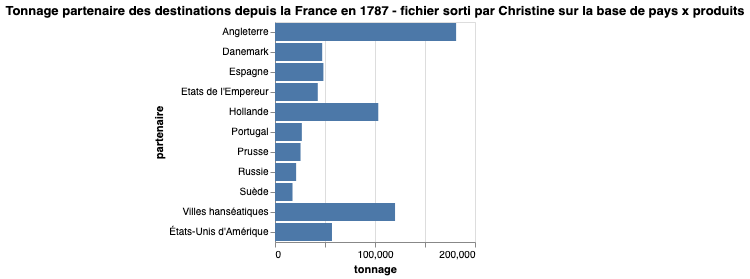

In [2]:
control_map = {}

transformation_map = {
      'Quatre villes hanséatiques': 'Villes hanséatiques',
      'Etats-Unis': 'États-Unis d\'Amérique',
      # 'Etats de l\'Empereur':''
    }
with open('../../../productions/module_12/export_france_1787_par_pays_par_produits.csv', newline='') as csvfile:
    rows_navigo = list(csv.DictReader(csvfile))
    control_map = {}
    for flow in rows_navigo:
      destination = flow["destination_partner_balance_1789"]
      if destination in transformation_map:
          destination = transformation_map[destination]
      tonnage = float(flow["sum_tonnage"] or 0)
      if destination not in control_map:
        control_map[destination] = 0
      control_map[destination] += tonnage
    
print("Agrégation des valeurs par pays à partir de l'extraction de Christine:")

print(pds.DataFrame([{"pays": pays, "tonnage": tonnage} for pays, tonnage in control_map.items()]))

viz_data = [{"partenaire": partenaire, "tonnage": tonnage} for partenaire, tonnage in control_map.items()]

VegaLite({
    "title": "Tonnage partenaire des destinations depuis la France en 1787 - fichier sorti par Christine sur la base de pays x produits",
    "data": {
        "values": viz_data
    },
    "mark": {"type": "bar", "tooltip": True},
    "encoding": {
        "x": {
            "type": "quantitative",
            "field": "tonnage"
        },
        "y": {
            "type": "nominal",
            "field": "partenaire",
            "sort": "y"
        }
    }
})


# 1.2. Test d'une seconde méthode à partir de l'API `raw_flows`

On refait le même compte en se basant sur les données disponibles en lignes via l'adresse raw_flows. On teste cette méthode pour s'assurer d'une meilleure reproductibilité pour la suite.

Filtres appliqués sur les flux navigo :

- departure_state_1789_fr = France
- departure_function = 'O'
- destination_state_1789_fr != France et destination_state_1789_fr != vide
- cargaison : on prend tous les flux sans cargaison, ou alors avec au moins une cargaison qui ne correspond pas à 'lest', 'lège', 'vide', ou 'futailles vides'

destinations navigo :
                     pays   tonnage
0                Danemark   40026.0
1              Angleterre  158827.0
2                  Russie   14503.0
3                 Espagne   36093.0
4                Hollande   73248.0
5                Portugal   34821.0
6     Villes hanséatiques   65623.0
7                   Suède   14059.0
8   États-Unis d'Amérique   19652.0
9     Etats de l'Empereur   28040.0
10                 Prusse   17179.0
tonnage total :  502071.0


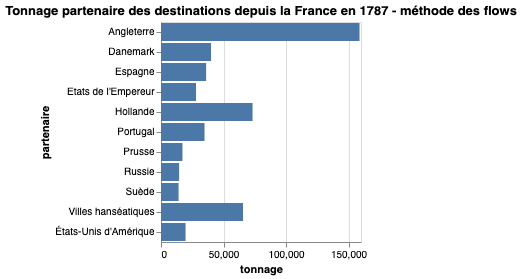

In [3]:
transformation_map = {
      'Quatre villes hanséatiques': 'Villes hanséatiques',
      'Etats-Unis': 'États-Unis d\'Amérique',
      # 'Etats de l\'Empereur':''
    }

destinations_navigo = {}
total_tonnage = 0
with open('../../../data/navigo_all_flows_1787.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
  stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
  total_commodities = set()
  for flow in flows:
    destination = flow['destination_partner_balance_1789']
    if destination in transformation_map:
      destination = transformation_map[destination]
    departure = flow['departure_state_1789_fr']
    tonnage = float(flow['tonnage'] or 0)
    if flow['departure_function'] == 'O' \
      and departure == 'France' \
      and destination != '' \
      and destination != 'France' \
      and flow['destination_state_1789_fr'] != 'France' :
      commodities = [flow[field].lower() for field in commodity_fields if flow[field] != '']
      not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
      # take the flow if no commodity specified or at least one 'not stop' commodity speciied
      if len(commodities) == 0 or len(not_stop) > 0:
        for c in not_stop:
          total_commodities.add(c)
        # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
        # at this point we have all the flows we want
        if destination not in destinations_navigo:
          destinations_navigo[destination] = 0
        destinations_navigo[destination] += tonnage
        total_tonnage += tonnage
      # else:
      #   print('removing flow with commodities :', commodities)
print('destinations navigo :')
print(pds.DataFrame([{"pays": pays, "tonnage": tonnage} for pays, tonnage in destinations_navigo.items()]))
print('tonnage total : ', str(total_tonnage))

viz_data = [{"partenaire": partenaire, "tonnage": tonnage} for partenaire, tonnage in destinations_navigo.items()]

VegaLite({
    "title": "Tonnage partenaire des destinations depuis la France en 1787 - méthode des flows",
    "data": {
        "values": viz_data
    },
    "mark": {"type": "bar", "tooltip": True},
    "encoding": {
        "x": {
            "type": "quantitative",
            "field": "tonnage"
        },
        "y": {
            "type": "nominal",
            "field": "partenaire",
            "sort": "y"
        }
    }
})


destinations navigo :
                     pays   tonnage
0                Danemark   40026.0
1              Angleterre  140785.0
2                  Russie   14503.0
3                 Espagne   36093.0
4                Hollande   73248.0
5                Portugal   33931.0
6     Villes hanséatiques   65623.0
7                   Suède   14059.0
8   États-Unis d'Amérique   19652.0
9     Etats de l'Empereur   28040.0
10                 Prusse   17179.0
tonnage total :  483139.0


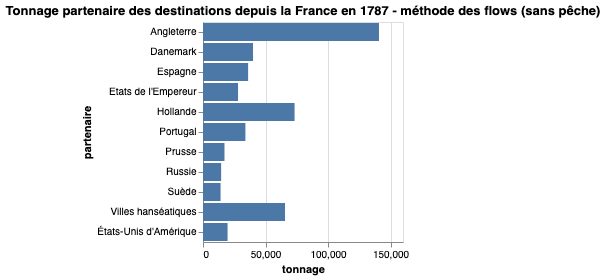

In [4]:
transformation_map = {
      'Quatre villes hanséatiques': 'Villes hanséatiques',
      'Etats-Unis': 'États-Unis d\'Amérique',
      # 'Etats de l\'Empereur':''
    }

destinations_navigo = {}
total_tonnage = 0
with open('../../../data/navigo_all_flows_1787.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
  stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
  commodity_id_fields = ['commodity_id', 'commodity_id2', 'commodity_id3', 'commodity_id4']
  fishing_commodities_ids = set(['00000012','00000240','00000240','00000280','00000306','00000307','00000328','00000329','00000331','00000332','00000336',])
  total_commodities = set()
  for flow in flows:
    destination = flow['destination_partner_balance_1789']
    if destination in transformation_map:
      destination = transformation_map[destination]
    departure = flow['departure_state_1789_fr']
    tonnage = float(flow['tonnage'] or 0)

    if flow['departure_function'] == 'O' \
      and departure == 'France' \
      and destination != '' \
      and destination != 'France' \
      and flow['destination_state_1789_fr'] != 'France' :
      commodities = [flow[field].lower() for field in commodity_fields if flow[field] != '']
      commodities_ids = [flow[field].lower() for field in commodity_id_fields if flow[field] != '']
      peche_ids = [commodity for commodity in commodities_ids if commodity in fishing_commodities_ids]
      not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
      
      # take the flow if no commodity specified or at least one 'not stop' commodity speciied
      if len(commodities) == 0 or (len(not_stop) > 0 and len(peche_ids) == 0):
        for c in not_stop:
          total_commodities.add(c)
        # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
        # at this point we have all the flows we want
        if destination not in destinations_navigo:
          destinations_navigo[destination] = 0
        destinations_navigo[destination] += tonnage
        total_tonnage += tonnage
      # else:
      #   print('removing flow with commodities :', commodities)
print('destinations navigo :')
print(pds.DataFrame([{"pays": pays, "tonnage": tonnage} for pays, tonnage in destinations_navigo.items()]))
print('tonnage total : ', str(total_tonnage))

viz_data = [{"partenaire": partenaire, "tonnage": tonnage} for partenaire, tonnage in destinations_navigo.items()]

VegaLite({
    "title": "Tonnage partenaire des destinations depuis la France en 1787 - méthode des flows (sans pêche)",
    "data": {
        "values": viz_data
    },
    "mark": {"type": "bar", "tooltip": True},
    "encoding": {
        "x": {
            "type": "quantitative",
            "field": "tonnage"
        },
        "y": {
            "type": "nominal",
            "field": "partenaire",
            "sort": "y"
        }
    }
})


In [5]:
# export for silvia
transformation_map = {
      'Quatre villes hanséatiques': 'Villes hanséatiques',
      'Etats-Unis': 'États-Unis d\'Amérique',
      # 'Etats de l\'Empereur':''
    }

destinations_navigo = {}
total_tonnage = 0
with open('../../../data/navigo_all_flows_1787.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
  commodity_id_fields = ['commodity_id', 'commodity_id2', 'commodity_id3', 'commodity_id4']
  stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
  fishing_commodities_ids = set(['00000012','00000240','00000240','00000280','00000306','00000307','00000328','00000329','00000331','00000332','00000336',])
  total_commodities = set()
  for flow in flows:
    destination = flow['destination_partner_balance_1789']
    if destination in transformation_map:
      destination = transformation_map[destination]
    departure = flow['departure_state_1789_fr']
    tonnage = float(flow['tonnage'] or 0)

    if flow['departure_function'] == 'O' \
      and departure == 'France' \
      and destination != '' \
      and destination != 'France' \
      and flow['destination_state_1789_fr'] != 'France' :
      commodities = [flow[field].lower() for field in commodity_fields if flow[field] != '']
      commodities_ids = [flow[field].lower() for field in commodity_id_fields if flow[field] != '']
      peche_ids = [commodity for commodity in commodities_ids if commodity in fishing_commodities_ids]
      not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
      
      # take the flow if no commodity specified or at least one 'not stop' commodity speciied
      if len(commodities) == 0 or (len(not_stop) > 0 and len(peche_ids) == 0):
        for c in not_stop:
          total_commodities.add(c)
        # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
        # at this point we have all the flows we want
        if destination not in destinations_navigo:
          destinations_navigo[destination] = {
              'tonnage_sans_vide_ni_peche': 0,
              'tonnage_vide': 0,
              'tonnage_peche': 0
          }
        destinations_navigo[destination]['tonnage_sans_vide_ni_peche'] += tonnage
        total_tonnage += tonnage
      elif len(not_stop) == 0:
        if destination not in destinations_navigo:
          destinations_navigo[destination] = {
              'tonnage_sans_vide_ni_peche': 0,
              'tonnage_vide': 0,
              'tonnage_peche': 0
          }
        destinations_navigo[destination]['tonnage_vide'] += tonnage
      else:
        if destination not in destinations_navigo:
          destinations_navigo[destination] = {
              'tonnage_sans_vide_ni_peche': 0,
              'tonnage_vide': 0,
              'tonnage_peche': 0
          }
        destinations_navigo[destination]['tonnage_peche'] += tonnage
      # else:
      #   print('removing flow with commodities :', commodities)
#print('destinations navigo :')
#print(pds.DataFrame([{"pays": pays, **tonnage} for pays, tonnage in destinations_navigo.items()]))
#pds.DataFrame([{"pays": pays, **tonnage} for pays, tonnage in destinations_navigo.items()]).to_csv('export_navigo_1787_destinations_flows.csv')
#print('tonnage total : ', str(total_tonnage))

Première analyse : résultats légèrement différents par rapport à la méthode précédente, avec des tonnages généralement moins importants (est-ce à cause de l'exclusion des vides ? ou du `departure_function=O` ?)

## 1.3. Méthode à partir des pointcalls 1787

Pour controller, on teste également une méthode se basant sur les pointcalls.

Filtrage appliqué aux pointcalls :

- pointcall_type = 'In'
- state_1789_fr != France et state_1789_fr != vide
- cargaison : on prend tous les flux sans cargaison, ou alors avec au moins une cargaison qui ne correspond pas à 'lest', 'lège', 'vide', ou 'futailles vides'

destinations navigo:
                     pays   tonnage
0              Angleterre  172450.0
1                 Espagne   73074.0
2                   Suède   14414.0
3                  Russie   30908.0
4                Danemark   41656.0
5                Portugal   41724.0
6     Villes hanséatiques   65899.0
7   États-Unis d'Amérique   24383.0
8     Etats de l'Empereur   30001.0
9                Hollande   74365.0
10                 Prusse   17322.0


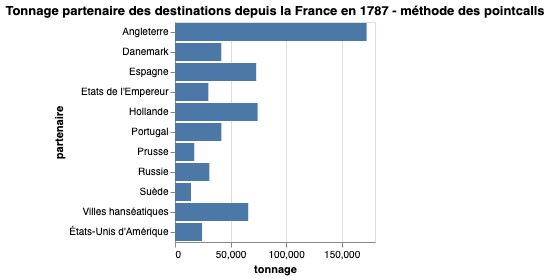

In [6]:
transformation_map = {
      'Quatre villes hanséatiques': 'Villes hanséatiques',
      'Etats-Unis': 'États-Unis d\'Amérique',
      # 'Etats de l\'Empereur':''
    }

destinations_navigo = {}
with open('../../../data/navigo_all_pointcalls_1787.csv', newline='') as csvfile:
  pointcalls = csv.DictReader(csvfile)
  commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
  stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
  total_commodities = set()
  for pointcall in pointcalls:
    destination = pointcall['partner_balance_1789']
    if destination in transformation_map:
      destination = transformation_map[destination]
    departure = pointcall['state_1789_fr']
    tonnage = float(pointcall['tonnage'] or 0)
    if destination != '' and pointcall['state_1789_fr'] != '' and pointcall['state_1789_fr'] != 'France' :
      commodities = [pointcall[field].lower() for field in commodity_fields if pointcall[field] != '']
      not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
      # take the flow if no commodity specified or at least one 'not stop' commodity speciied
      if len(commodities) == 0 or len(not_stop) > 0:
        for c in not_stop:
          total_commodities.add(c)
        # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
        # at this point we have all the flows we want
        if destination not in destinations_navigo:
          destinations_navigo[destination] = 0
        destinations_navigo[destination] += tonnage
      # else:
      #   print('removing flow with commodities :', commodities)
print('destinations navigo:')
print(pds.DataFrame([{"pays": pays, "tonnage": tonnage} for pays, tonnage in destinations_navigo.items()]))

viz_data = [{"partenaire": partenaire, "tonnage": tonnage} for partenaire, tonnage in destinations_navigo.items()]

VegaLite({
    "title": "Tonnage partenaire des destinations depuis la France en 1787 - méthode des pointcalls",
    "data": {
        "values": viz_data
    },
    "mark": {"type": "bar", "tooltip": True},
    "encoding": {
        "x": {
            "type": "quantitative",
            "field": "tonnage"
        },
        "y": {
            "type": "nominal",
            "field": "partenaire",
            "sort": "y"
        }
    }
})

Analyse : les données sont de nouveaux lègerement différentes. À noter : on n'a pas pris en compte les in-out dans ce cas précis, c'est peut-être l'explication.

## 1.4. Source F12 récoltée par Silvia


On teste enfin la source suivante, censée donner les tonnages par destination pour les bateaux pleins partis de France en 1787 : https://docs.google.com/spreadsheets/d/1Y_7tbin8s1D_xEtwMBHXleqQUwb8rvqM550yDEEk0w4/edit#gid=249173198

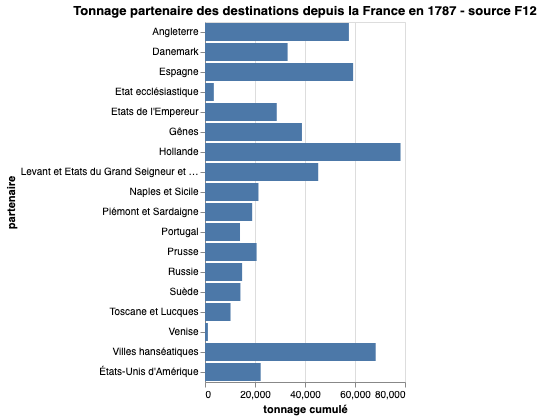

In [7]:
F12_SPREADSHEET_URL = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRHqTGjTMavPEw0Mf4RBjvXz5qhBjWV7a1gYuokEvaKRP-HzBSURdpCozaXzHHySXLKQWrQcO7LGk2K/pub?gid=249173198&single=true&output=csv'

destinations_f12 = get_online_csv(F12_SPREADSHEET_URL)

viz_data = [{"tonnage cumulé": item["tonnage_a_utiliser_clean"], "partenaire": item["destination_state_1789_fr"]} for item in destinations_f12]

VegaLite({
    "title": "Tonnage partenaire des destinations depuis la France en 1787 - source F12",
    "data": {
        "values": viz_data
    },
    "mark": {"type": "bar", "tooltip": True},
    "encoding": {
        "x": {
            "type": "quantitative",
            "field": "tonnage cumulé"
        },
        "y": {
            "type": "nominal",
            "field": "partenaire",
            "sort": "y"
        }
    }
})

Analyse : la Hollande se retrouve avec un tonnage beaucoup plus important que sur les autres sources, d'autres destinations telles que Danemark, Espagne, et Villes hanséatiques sont gonflées également. On dénote aussi des destinations nouvelles non présentes dans navigo (notamment en Italie).

In [8]:
# factorization
def get_navigo_f12_dict () :
    F12_SPREADSHEET_URL = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRHqTGjTMavPEw0Mf4RBjvXz5qhBjWV7a1gYuokEvaKRP-HzBSURdpCozaXzHHySXLKQWrQcO7LGk2K/pub?gid=249173198&single=true&output=csv'
    destinations_f12 = get_online_csv(F12_SPREADSHEET_URL)
    f12_dict = {}
    for item in destinations_f12:
        f12_dict[item['destination_state_1789_fr']] = float(item["tonnage_a_utiliser_clean"])
    return f12_dict

## 1.5. Conclusion de la vérification navigo

Les données de F12 sont très différentes de ce que l'on obtient avec navigo. On va utiliser cette source pour la suite.

# 2. stabilisation des données toflit18

On s'attelle maintenant à la vérification des données toflit18.


On va tester différentes sources de données pour s'assurer qu'il n'y a pas de disparités qui expliqueraient les chiffres bizarres obtenus pendant le 2ème datasprint.

## 2.1. Source "résumé"

Filtrage des flux toflit18 :

- année : 1787
- source_type : "Résumé"
- export_import : "Exports"

somme des exports selon résumé en 1787 :
                      partenaire     tonnage
0            Colonies françaises  95559900.0
1                        Espagne  40161200.0
2                       Hollande  33571500.0
3                         Prusse   9008500.0
4                      Allemagne  22464400.0
5                         Suisse  20531400.0
6          États-Unis d'Amérique   2050600.0
7            Villes hanséatiques  60194700.0
8                       Danemark   6334500.0
9                          Suède   5053700.0
10  Milanais, Toscane et Lucques  10847100.0
11                         Gênes   6286100.0
12    Empire Ottoman et Barbarie  25608100.0
13          Royaume de Sardaigne  19266630.0
14                      Autriche  33919600.0
15                        Russie   6630000.0
16                      Portugal   3935200.0
17         États ecclésiastiques   3421400.0
18                    Angleterre  34200500.0
19                        Naples   5355600.0
20            

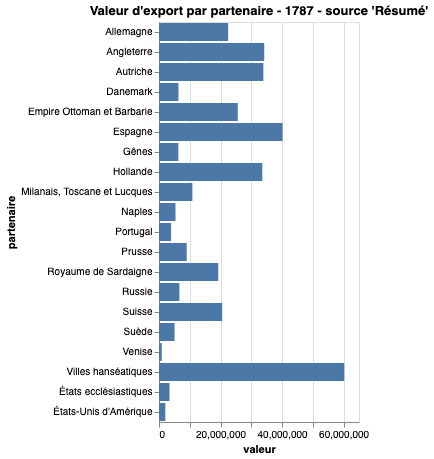

In [9]:
partners_toflit18 = {}
with open('../../../data/toflit18_all_flows.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  for flow in flows:
    if flow['source_type'] == 'Résumé' \
      and flow['year'] == '1787' \
      and flow['export_import'] == 'Exports':

      partner = flow['partner_simplification']
      value = float(flow['value'] or 0)
      if partner not in partners_toflit18:
        partners_toflit18[partner] = 0
      partners_toflit18[partner] += value
print('somme des exports selon résumé en 1787 :')
print(pds.DataFrame([{"partenaire": pays, "tonnage": tonnage} for pays, tonnage in partners_toflit18.items()]))


viz_data = [{"partenaire": partenaire, "valeur": valeur} for partenaire, valeur in partners_toflit18.items() if partenaire != 'Colonies françaises']

VegaLite({
    "title": "Valeur d'export par partenaire - 1787 - source 'Résumé'",
    "data": {
        "values": viz_data
    },
    "mark": {"type": "bar", "tooltip": True},
    "encoding": {
        "x": {
            "type": "quantitative",
            "field": "valeur"
        },
        "y": {
            "type": "nominal",
            "field": "partenaire",
            "sort": "y"
        }
    }
})

Note : après essais, on se rend compte qu'utiliser la source_type "Résumé" revient en fait exactement à utiliser `best_guess_national_partner` (au moins pour l'année 1787).

## 2.2. Méthode `best_guess_national_prodxpart`

Pour contrôler, on essaie de reproduire le calcul du total des exports fr en 1787 via les sources comprenant les produits. On aggrège toujours par partenaire.

Filtrage des flux toflit18 :

- année : 1787
- drapeau : "best_guess_national_prodxpart"
- export_import : "Exports"

sources utilisées:['Résumé']
partners_toflit18:
                      partenaire     tonnage
0            Colonies françaises  95559900.0
1                        Espagne  40161200.0
2                       Hollande  33571500.0
3                         Prusse   9008500.0
4                      Allemagne  22464400.0
5                         Suisse  20531400.0
6          États-Unis d'Amérique   2050600.0
7            Villes hanséatiques  60194700.0
8                       Danemark   6334500.0
9                          Suède   5053700.0
10  Milanais, Toscane et Lucques  10847100.0
11                         Gênes   6286100.0
12    Empire Ottoman et Barbarie  25608100.0
13          Royaume de Sardaigne  19266630.0
14                      Autriche  33919600.0
15                        Russie   6630000.0
16                      Portugal   3935200.0
17         États ecclésiastiques   3421400.0
18                    Angleterre  34200500.0
19                        Naples   5355600.0
20     

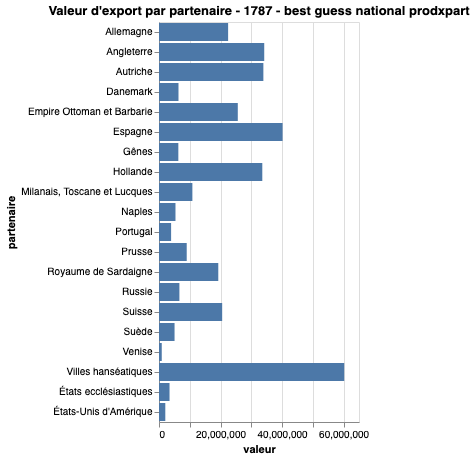

In [10]:
partners_toflit18 = {}
sources = set()
with open('../../../data/toflit18_all_flows.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  for flow in flows:
    if flow['best_guess_national_prodxpart'] == '1' \
      and flow['year'] == '1787' \
      and flow['export_import'] == 'Exports':

      partner = flow['partner_simplification']
      sources.add(flow['source_type'])
      value = float(flow['value'] or 0)
      if partner not in partners_toflit18:
        partners_toflit18[partner] = 0
      partners_toflit18[partner] += value

print('sources utilisées:' + str(list(sources)))
print('partners_toflit18:')
print(pds.DataFrame([{"partenaire": pays, "tonnage": tonnage} for pays, tonnage in partners_toflit18.items()]))


viz_data = [{"partenaire": partenaire, "valeur": valeur} for partenaire, valeur in partners_toflit18.items() if partenaire != 'Colonies françaises']

VegaLite({
    "title": "Valeur d'export par partenaire - 1787 - best guess national prodxpart",
    "data": {
        "values": viz_data
    },
    "mark": {"type": "bar", "tooltip": True},
    "encoding": {
        "x": {
            "type": "quantitative",
            "field": "valeur"
        },
        "y": {
            "type": "nominal",
            "field": "partenaire",
            "sort": "y"
        }
    }
})

Analyse : les données sont identiques, c'est toujours la source "Résumé" qui est utilisée. Cela valide l'accès aux données toflit18 comme stable. Néanmoins subsiste un problème : les exports peuvent se faire par mer ou par terre pour certains partenaires ...

On note certains partenaires vers lesquelles une valeur particulièrement importante de marchandise a été exportée : Hollande, Villes Hanséatiques, Espagne, Angleterre. 

D'un point de vue méthodologique et vis-à-vis de la suite, la question est de savoir si les échanges qui produisent ces valeurs correspondent à des échanges marins, et s'ils sont spécifiques à l'année 1787.

Avant d'aller plus loin, inspectons quels sont les produits qui produisent ces irrégularités remarquables.

### 2.3. Interlude : zoom sur les exports toflit18 nationaux par produits

On prend le temps de visualiser de quoi sont composées les valeurs du graphique précédents.

Filtrage des flux toflit18 :

- année : 1787
- drapeau : "best_guess_national_prodxpart"
- export_import : "Exports"
- partner_simplification différent de 'Colonies françaises'

Puis on visualise les valeurs par produit et partenaire agrégés selon la classification "révolution et empire" :

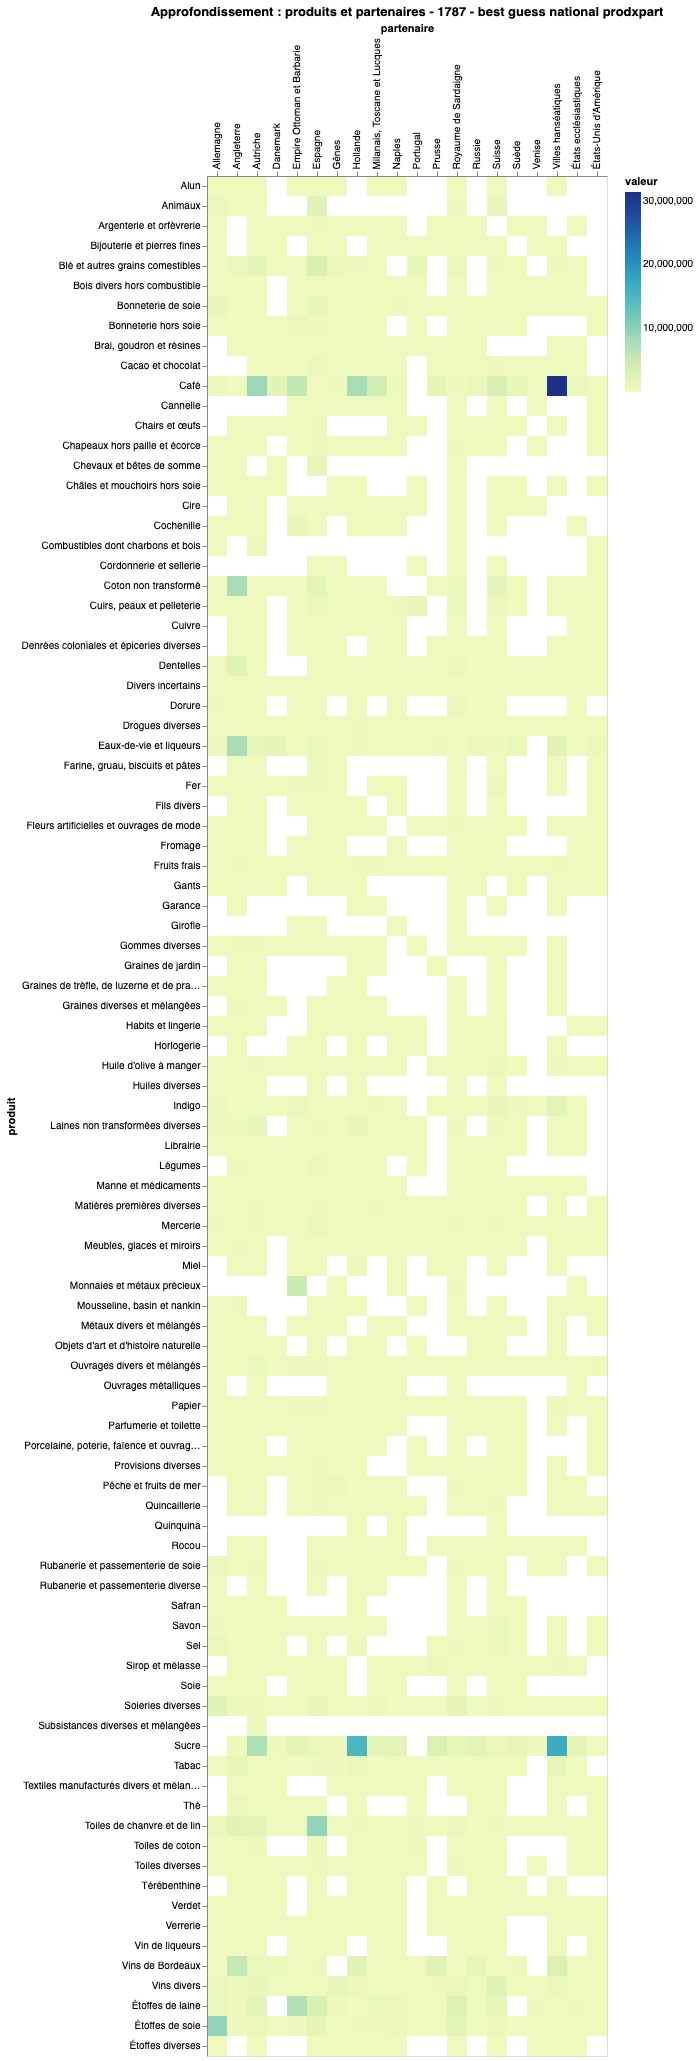

In [11]:
partxprod = {}
with open('../../../data/toflit18_all_flows.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  for flow in flows:
    if flow['best_guess_national_prodxpart'] == '1' \
      and flow['year'] == '1787' \
      and flow['export_import'] == 'Exports' \
      and flow['partner_simplification'] != 'Colonies françaises':

      partner = flow['partner_simplification']
      product = flow['product_revolutionempire']
      value = float(flow['value'] or 0)
      if partner not in partxprod:
        partxprod[partner] = {}
      if product not in partxprod[partner]:
        partxprod[partner][product] = 0
      partxprod[partner][product] += value
    
viz_data = []
for partner, products in partxprod.items():
    for product, value in products.items():
        viz_data.append({
            "partenaire": partner,
            "produit": product,
            "valeur": value
        })

VegaLite({
    "title": "Approfondissement : produits et partenaires - 1787 - best guess national prodxpart",
    "data": {
        "values": viz_data
    },
    "mark": {"type": "rect", "tooltip": True},
    "encoding": {
        "color": {
            "type": "quantitative",
            "field": "valeur"
        },
        "x": {
            "type": "nominal",
            "field": "partenaire",
            "sort": "x",
            "axis": {
                "orient": "top"
            }
        },
        "y": {
            "type": "nominal",
            "field": "produit"
        },
        
    }
})

Analyse : pour l'Espagne, on voit qu'elle est l'objet d'un import de monnaies et métaux précieux depuis la France très important : après investigation, il s'agit d'un unique flux de "lingots ou monnaies étrangères d'argent et d'or" (est-il régulier sur les autres années ?).

Pour Hollande, Villes Hanséatiques, et Angleterre, on ne note pas de type de produit à la valeur exceptionnel qui pourrait représenter une irrégularité avec 1789 (?).

Il faut maintenant être capable de distinguer les flux faits par terre et par mer.

## 2.3. Utilisation de la source terre-mer

Il s'agit de distinguer, pour chaque partenaire, la portion des flux vraisemblement effectués par la mer. Cette information n'est disponible que de manière agrégée par partenaire pour 1792, on va donc utiliser une source nous donnant cette information.

Le décompte des exports par terre et par mer pour 1792 est consigné dans ce fichier google spreadsheet : https://docs.google.com/spreadsheets/d/1d0peowoVhblBWtHkGxO0V1_H201rUAWd_arI0LbPfXc/edit#gid=373560562

L'image de la source originale est ici : https://drive.google.com/file/d/1tLsLCy3Wn22IqMxRO71koSUpH4jXogVM/view?usp=sharing

On utilise cette source pour avoir une estimation des sommes d'export par la mer pour chaque partenaire de 1787, ainsi qu'une estimation du ratio terre/mer permettant d'approximer la répartition des valeurs entre terre et mer pour d'autres flux toflit18.

*Note : ce ratio est une importante approximation dans notre méthodologie, mais au vu des données ensuite concernées il n'aura pas un très gros impact sur les chiffres.*

On dispose de deux valeurs pour chaque partenaire dans la source terre-mer : les valeurs d'exports par la mer, et par la terre. On commence par visualiser la somme des deux, puis les valeurs d'exports par la mer seulement :

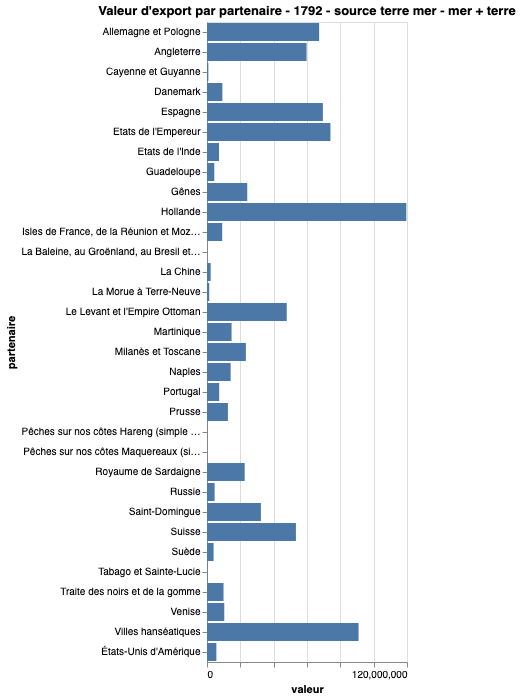

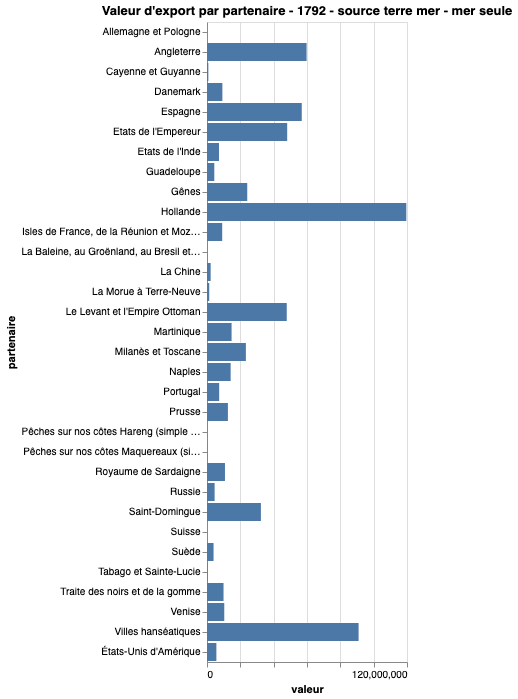

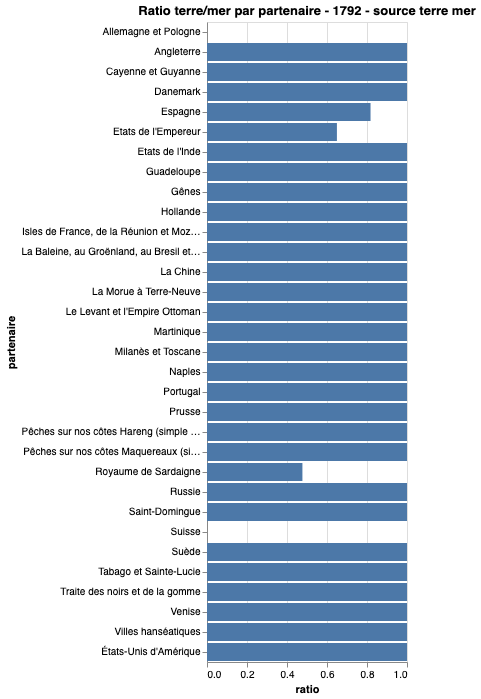

In [12]:
# Compute terre mer partition

with open('./terre_mer.csv', newline='') as csvfile:
    rows_terremer = list(csv.DictReader(csvfile))
# print(pds.DataFrame(rows_terremer))
terre_mer_ratio = {}
terre_mer = {}
mer_seule = {}
for row in rows_terremer:
  if row['partner'] not in terre_mer:
    partner = row['partner']
    transformation_map = {
      'Villes Anséatiques': 'Villes hanséatiques',
      'Danemarck et Norwège': 'Danemark',
      'République de Gênes': 'Gênes',
      'Naples et Sicile': 'Naples',
      'États du Roi de Sardaigne': 'Royaume de Sardaigne',
      'Angleterre, Ecosse et Irlande': 'Angleterre',
      'Rome et Venise': 'Venise',
      'États de l\'Empereur, en Flandre et Allemagne': 'Etats de l\'Empereur',
      'Suisse, ses Alliées et Genève': 'Suisse'
    }
    if partner in transformation_map:
      partner = transformation_map[partner]
    terre_mer_ratio[partner] = float(row['ratio_terre_mer'])
    terre_mer[partner] = float(row['somme_mer']) + float(row['somme_terre'])
    mer_seule[partner] = float(row['somme_mer'])
    
VegaLite({
    "title": "Valeur d'export par partenaire - 1792 - source terre mer - mer + terre",
    "data": {
        "values": [{"partenaire": partenaire, "valeur": valeur} for partenaire, valeur in terre_mer.items() if partenaire != 'Colonies françaises']
    },
    "mark": {"type": "bar", "tooltip": True},
    "encoding": {
        "x": {
            "type": "quantitative",
            "field": "valeur"
        },
        "y": {
            "type": "nominal",
            "field": "partenaire",
            "sort": "y"
        }
    }
})
VegaLite({
    "title": "Valeur d'export par partenaire - 1792 - source terre mer - mer seule",
    "data": {
        "values": [{"partenaire": partenaire, "valeur": valeur} for partenaire, valeur in mer_seule.items() if partenaire != 'Colonies françaises']
    },
    "mark": {"type": "bar", "tooltip": True},
    "encoding": {
        "x": {
            "type": "quantitative",
            "field": "valeur"
        },
        "y": {
            "type": "nominal",
            "field": "partenaire",
            "sort": "y"
        }
    }
})
VegaLite({
    "title": "Ratio terre/mer par partenaire - 1792 - source terre mer",
    "data": {
        "values": [{"partenaire": partenaire, "ratio": ratio} for partenaire, ratio in terre_mer_ratio.items() if partenaire != 'Colonies françaises']
    },
    "mark": {"type": "bar", "tooltip": True},
    "encoding": {
        "x": {
            "type": "quantitative",
            "field": "ratio"
        },
        "y": {
            "type": "nominal",
            "field": "partenaire",
            "sort": "y"
        }
    }
})

Première analyse : Allemagne et Pologne sont classé comme 0% mer, ce qui est étonnant (comme les Etats de l'Inde). Certaines valeurs pourraient être agrégées pour affiner les comptages.

Pour affiner, il pourrait être intéressant d'aligner ces noms de partenaires avec la classification simplification. Mais au vu des données ensuite concernées pour Dunkerque, cela ne devrait pas avoir un gros impact (?).

# 3. Essais de projection

On va maintenant tester le calcul des prix par tonneau par partenaire, en utilisant les données toflit18 "Résumé" en pondérant les valeurs par le ratio terre/mer calculé grâce à la source terre-mer.


Filtrage des flux toflit18 :

- année : 1787
- source_type : "Résumé"
- export_import : "Exports"
- partner_simplification différent de 'Colonies françaises'



Filtres appliqués sur les flux navigo :

- departure_state_1789_fr = France
- departure_function = 'O'
- destination_state_1789_fr != France et destination_state_1789_fr != vide
- cargaison : on prend tous les flux sans cargaison, ou alors avec au moins une cargaison qui ne correspond pas à 'lest', 'lège', 'vide', ou 'futailles vides'



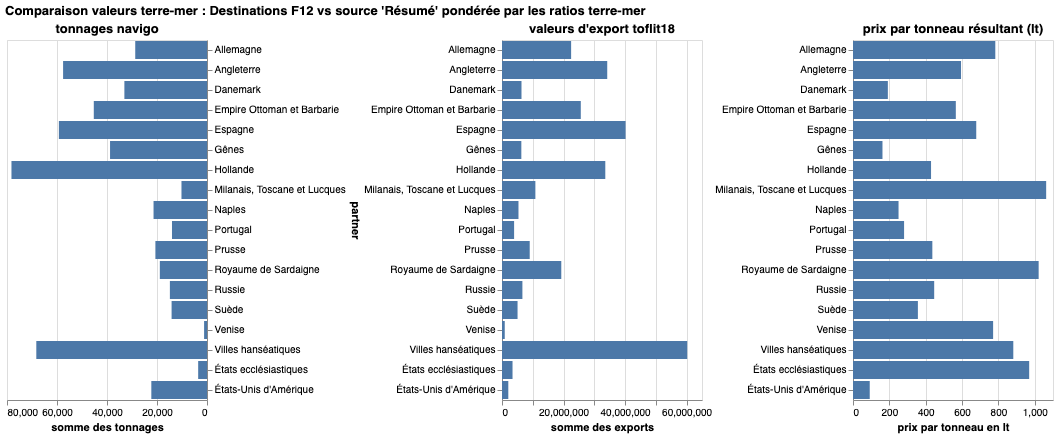

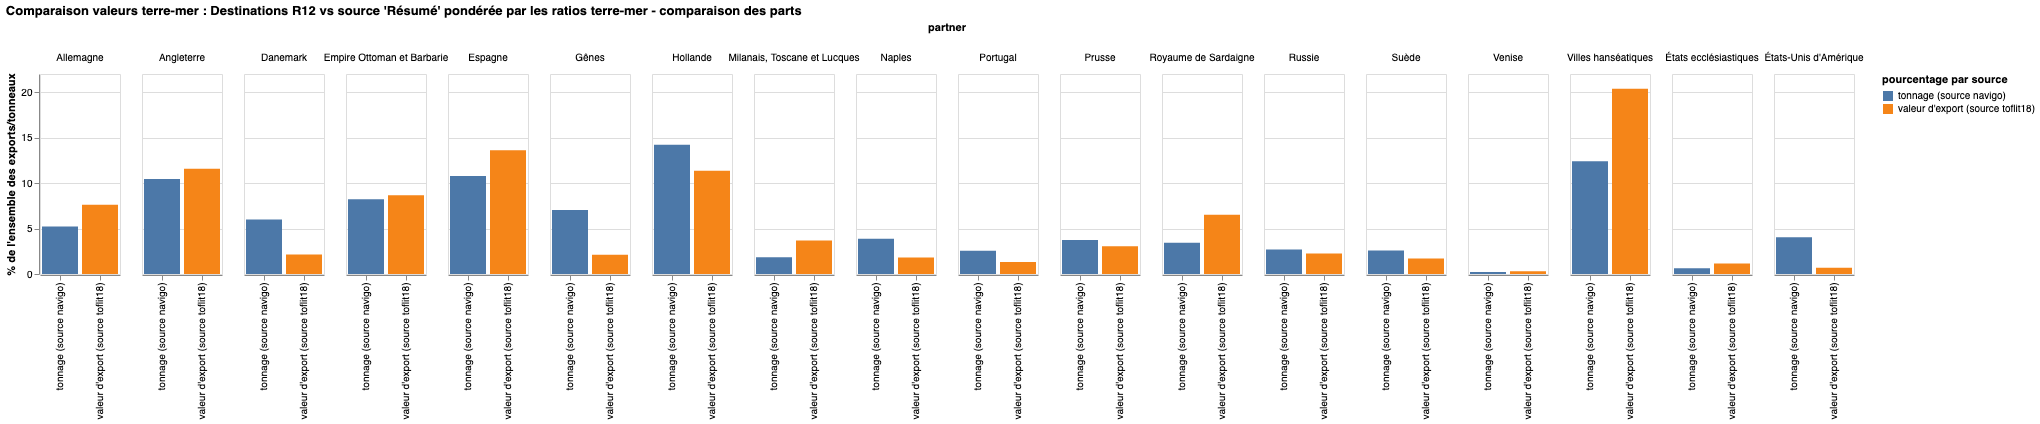

In [13]:
transformation_map = {
      'Quatre villes hanséatiques': 'Villes hanséatiques',
      'Etats-Unis': 'États-Unis d\'Amérique',
      # 'Etats de l\'Empereur':''
    }

destinations_navigo_original = get_navigo_f12_dict()

navigo_f12_to_toflit18 = {
    'Levant et Etats du Grand Seigneur et de Barbarie': 'Empire Ottoman et Barbarie',
    'Etat ecclésiastique': 'États ecclésiastiques',
    'Piémont et Sardaigne': 'Royaume de Sardaigne',
    'Naples et Sicile': 'Naples',
    'Toscane et Lucques': 'Milanais, Toscane et Lucques',
    'Etats de l\'Empereur': 'Allemagne'
}
destinations_navigo = {}
for key, val in destinations_navigo_original.items():
    if key in navigo_f12_to_toflit18:
        destinations_navigo[navigo_f12_to_toflit18[key]] = val
    else:
        destinations_navigo[key] = val

"""
destinations_navigo = {}
with open('../../../data/navigo_all_flows_1787.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
  stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
  total_commodities = set()
  for flow in flows:
    destination = flow['destination_partner_balance_1789']
    if destination in transformation_map:
      destination = transformation_map[destination]
    departure = flow['departure_state_1789_fr']
    tonnage = float(flow['tonnage'] or 0)
    if flow['departure_function'] == 'O' \
      and departure == 'France' \
      and destination != '' \
      and destination != 'France' \
      and flow['destination_state_1789_fr'] != 'France' :
      commodities = [flow[field].lower() for field in commodity_fields if flow[field] != '']
      not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
      # take the flow if no commodity specified or at least one 'not stop' commodity speciied
      if len(commodities) == 0 or len(not_stop) > 0:
        for c in not_stop:
          total_commodities.add(c)
        # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
        # at this point we have all the flows we want
        if destination not in destinations_navigo:
          destinations_navigo[destination] = 0
        destinations_navigo[destination] += tonnage
"""
        
with open('./terre_mer.csv', newline='') as csvfile:
    rows_terremer = list(csv.DictReader(csvfile))

terre_mer_ratio = {}
terre_mer = {}
mer_seule = {}
for row in rows_terremer:
  if row['partner'] not in terre_mer:
    partner = row['partner']
    transformation_map = {
      'Villes Anséatiques': 'Villes hanséatiques',
      'Danemarck et Norwège': 'Danemark',
      'République de Gênes': 'Gênes',
      'Naples et Sicile': 'Naples',
      'États du Roi de Sardaigne': 'Royaume de Sardaigne',
      'Angleterre, Ecosse et Irlande': 'Angleterre',
      'Rome et Venise': 'Venise',
      'États de l\'Empereur, en Flandre et Allemagne': 'Etats de l\'Empereur',
      'Suisse, ses Alliées et Genève': 'Suisse'
    }
    if partner in transformation_map:
      partner = transformation_map[partner]
    terre_mer_ratio[partner] = float(row['ratio_terre_mer'])
    terre_mer[partner] = float(row['somme_mer']) + float(row['somme_terre'])
    mer_seule[partner] = float(row['somme_mer'])

partners_toflit18 = {}
with open('../../../data/toflit18_all_flows.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  for flow in flows:
    if flow['source_type'] == 'Résumé' \
      and flow['year'] == '1787' \
      and flow['partner_simplification'] != 'Colonies françaises' \
      and flow['export_import'] == 'Exports':

      partner = flow['partner_simplification']
      if partner == "États de l'Empereur":
            partner = "Etats de l'Empereur"
      value = float(flow['value'] or 0)
      if partner not in partners_toflit18:
        partners_toflit18[partner] = 0
      partners_toflit18[partner] += value
partners_toflit18_corrected = {}
for (partner, value) in partners_toflit18.items():
  ratio = 1
  
  if partner in terre_mer:
    ratio = float(terre_mer[partner])
  # else:
  #   print('ratio : issue with partner: ', partner)
  partners_toflit18_corrected[partner] = value * ratio


# partners_toflit18 = partners_toflit18_corrected

correspondance = []
for destination, tonnage in destinations_navigo.items():
  if destination not in partners_toflit18:
    print('Note : un pays présent dans les destinations navigo F12 (1787) n\'est pas dans les partenaires des flux toflit18 sélectionnés :', destination)
  else:
    value = partners_toflit18[destination]
    correspondance.append({
      "partner": destination,
      "sum_tonnage": tonnage,
      "sum_exports": value,
      "price_per_barrel": value / tonnage
    })

VegaLite({
    "title": "Comparaison valeurs terre-mer : Destinations F12 vs source 'Résumé' pondérée par les ratios terre-mer",
    "data": {
        "values": correspondance
    },
    "spacing": 0,
    "hconcat": [
        {
            "title": "tonnages navigo",
            "mark": {"type": "bar", "tooltip": True},
            "encoding": {
                "x": {
                    "type": "quantitative",
                    "field": "sum_tonnage",
                    "title": "somme des tonnages",
                    "sort": "descending"
                },
                "y": {
                    "field": "partner",
                    "type": "nominal",
                    "axis": {"orient": "right"}
                }
            }
        },
        {
            "title": "valeurs d'export toflit18",
            "mark": {"type": "bar", "tooltip": True},
            "encoding": {
                "x": {
                    "type": "quantitative",
                    "field": "sum_exports",
                    "title": "somme des exports"
                },
                "y": {
                    "field": "partner",
                    "type": "nominal",
                    "axis": {"title": ""}
                }
            }
        },
        {
            "title": "prix par tonneau résultant (lt)",
            "mark": {"type": "bar", "tooltip":  True},
            "encoding": {
                "x": {
                    "type": "quantitative",
                    "field": "price_per_barrel",
                    "title": "prix par tonneau en lt"
                },
                "y": {
                    "field": "partner",
                    "type": "nominal",
                    "axis": {"title": ""}
                }
            }
        }
    ]
})

# relative comparison

total_tonnage = 0
total_value = 0
for c in correspondance:
    total_tonnage += c["sum_tonnage"]
    total_value += c["sum_exports"]
for c in correspondance:
    c["part_tonnage"] = c["sum_tonnage"] / total_tonnage * 100
    c["part_value"] = c["sum_exports"] / total_value * 100
in_part = []
for c in correspondance:
    in_part.append({
        "partner": c["partner"],
        "value": c["part_tonnage"],
        "group": "tonnage (source navigo)"
    })
    in_part.append({
        "partner": c["partner"],
        "value": c["part_value"],
        "group": "valeur d'export (source toflit18)"
    })
    

VegaLite({
    "title": "Comparaison valeurs terre-mer : Destinations R12 vs source 'Résumé' pondérée par les ratios terre-mer - comparaison des parts",
    "data": {
        "values": in_part
    },
    "width": 80,
    "mark": {"type": "bar", "tooltip": True},
      "encoding": {
        "column": {"field": "partner"},
        "y": {
            "field": "value", "type": "quantitative",
            "title": "% de l'ensemble des exports/tonneaux"
        },
        "x": {
            "field": "group",
            "axis": {"title": ""}
        },
        "color": {
            "field": "group",
            "title": "pourcentage par source"
        }
      }
})

Première analyse :

La plupart des ratios tonnage/prix semblent cohérents.

Certaines detinations ont une part d'exports plus importante que leur part de tonnage, ce qui donne un important prix par tonneaux (notamment, destinations italiennes et villes hanséatiques).

On voit apparaître des pays avec une forte disparité au profit de la navigation (ce qui veut correspond à des échanges de produits peu rentables du point de vue transport) : Gênes, Danemark, Portugal, USA. Cela provoque des prix par tonneaux relativement bas.

## 3.3. Conclusion des tests pour établir le modèle

On a établi une méthode pour calculer un prix par tonneau par partenaire à partir de 1787.

Il est à noter qu'il faudra s'adapter à l'apparition de nouveaux partenaires ou destinations pour 1787 pour des flux locaux.

Il faut maintenant tester le modèle obtenu avec des données où l'on dispose à la fois de navigo et de toflit18.

# 4. Vérification du modèle sur des ensembles de données complets dans PASA

In [14]:
# Turning the computation into a function
def compute_price_per_barrel_per_destination(method="résumé", verbose = False):
    # compute destinations navigo general
    transformation_map = {
          'Quatre villes hanséatiques': 'Villes hanséatiques',
          'Etats-Unis': 'États-Unis d\'Amérique',
          # 'Etats de l\'Empereur':''
        }
    """
    destinations_navigo_national = {}
    with open('../../../data/navigo_all_flows_1787.csv', newline='') as csvfile:
      flows = csv.DictReader(csvfile)
      commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
      stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
      total_commodities = set()
      for flow in flows:
        destination = flow['destination_partner_balance_1789']
        if destination in transformation_map:
          destination = transformation_map[destination]
        departure = flow['departure_state_1789_fr']
        tonnage = float(flow['tonnage'] or 0)
        if flow['departure_function'] == 'O' \
          and departure == 'France' \
          and destination != '' \
          and destination != 'France' \
          and flow['destination_state_1789_fr'] != 'France' :
          commodities = [flow[field].lower() for field in commodity_fields if flow[field] != '']
          not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
          # take the flow if no commodity specified or at least one 'not stop' commodity speciied
          if len(commodities) == 0 or len(not_stop) > 0:
            for c in not_stop:
              total_commodities.add(c)
            # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
            # at this point we have all the flows we want
            if destination not in destinations_navigo_national:
              destinations_navigo_national[destination] = 0
            destinations_navigo_national[destination] += tonnage
    """
    destinations_navigo_original = get_navigo_f12_dict()
    navigo_f12_to_toflit18 = {
        'Levant et Etats du Grand Seigneur et de Barbarie': 'Empire Ottoman et Barbarie',
        'Etat ecclésiastique': 'États ecclésiastiques',
        'Piémont et Sardaigne': 'Royaume de Sardaigne',
        'Naples et Sicile': 'Naples',
        'Toscane et Lucques': 'Milanais, Toscane et Lucques',
        'Etats de l\'Empereur': 'Allemagne'
    }
    destinations_navigo_national = {}
    for key, val in destinations_navigo_original.items():
        if key in navigo_f12_to_toflit18:
            destinations_navigo_national[navigo_f12_to_toflit18[key]] = val
        else:
            destinations_navigo_national[key] = val

            
    with open('./terre_mer.csv', newline='') as csvfile:
            rows_terremer = list(csv.DictReader(csvfile))

    terre_mer_ratio = {}
    terre_mer = {}
    mer_seule = {}
    for row in rows_terremer:
      if row['partner'] not in terre_mer:
        partner = row['partner']
        transformation_map = {
          'Villes Anséatiques': 'Villes hanséatiques',
          'Danemarck et Norwège': 'Danemark',
          'République de Gênes': 'Gênes',
          'Naples et Sicile': 'Naples',
          'États du Roi de Sardaigne': 'Royaume de Sardaigne',
          'Angleterre, Ecosse et Irlande': 'Angleterre',
          'Rome et Venise': 'Venise',
          'États de l\'Empereur, en Flandre et Allemagne': 'Etats de l\'Empereur',
          'Suisse, ses Alliées et Genève': 'Suisse'
        }
        if partner in transformation_map:
          partner = transformation_map[partner]
        terre_mer_ratio[partner] = float(row['ratio_terre_mer'])
        terre_mer[partner] = float(row['somme_mer']) + float(row['somme_terre'])
        mer_seule[partner] = float(row['somme_mer'])
    if verbose is True:
        print("ratios obtenus : ")
        print(pds.DataFrame([{"partenaire": partenaire, "ratio": ratio} for partenaire, ratio in terre_mer_ratio.items()]))
            
    toflit18_map = {}
    if method == 'mer seule':
        # rely on mer seule (@todo remove that)
        toflit18_map = mer_seule 
    elif method == 'résumé':
        # compute sums of exports at national level
        partners_toflit18_national = {}
        with open('../../../data/toflit18_all_flows.csv', newline='') as csvfile:
          flows = csv.DictReader(csvfile)
          for flow in flows:
            if flow['source_type'] == 'Résumé' \
              and flow['year'] == '1787' \
              and flow['export_import'] == 'Exports':

              partner = flow['partner_simplification']
              if partner == 'États de l\'Empereur':
                partner = 'Etats de l\'Empereur'
              value = float(flow['value'] or 0)
              if partner not in partners_toflit18_national:
                partners_toflit18_national[partner] = 0
              partners_toflit18_national[partner] += value
        # correct sums of exports at national level with ratios
        partners_toflit18_national_corrected = {}
        for (partner, value) in partners_toflit18_national.items():
          ratio = 1

          if partner in terre_mer:
            ratio = float(terre_mer_ratio[partner])
          # else:
          #  print('ratio : ce partenaire n\'est pas disponible dans la table des ratios : ', partner)
          partners_toflit18_national_corrected[partner] = value * ratio
        toflit18_map = partners_toflit18_national_corrected
        

    correspondance = []
    for destination, tonnage in destinations_navigo_national.items():
      if destination not in toflit18_map:
        print('problème, le pays de destination navigo suivant n\'est pas dans la source terre-mer pour 1787 :', destination)
      else:
        value = toflit18_map[destination]
        correspondance.append({
          "partner": destination,
          "sum_tonnage": tonnage,
          "sum_exports": value,
          "price_per_barrel": value / tonnage
        })
    if verbose:
        print('table de correspondance : ')
        print(pds.DataFrame(correspondance))
    return correspondance, terre_mer_ratio

# compute_price_per_barrel_per_destination(verbose=True, method='résumé')

## 4.1. Test sur les données du bureau des fermes de La Rochelle en 1789

Pour tester les prix par tonneau obtenus avec notre méthode, on va les appliquer aux départs du port de La Rochelle en 1789, et les comparer aux exports cumulés toflit18 pour le bureau des fermes de La Rochelle la même année.

**On s'attend à avoir des valeurs similaires par partenaires entre la valeur calculée et la valeur des sources toflit18.** Plus la valeur calculée et la valeur sont "proches", plus on s'assure que la projection sur Dunkerque est crédible.

### 4.1.1. Analyse préliminaire des données

On commence par visualiser la répartition des destinations des trajets pour le port de La Rochelle en 1789.

Filtres appliqués sur les flux navigo 1789 :

- departure_ferme_bureau = La Rochelle
- departure_function = 'O'
- destination_state_1789_fr != France et destination_state_1789_fr != vide
- cargaison : on prend tous les flux sans cargaison, ou alors avec 
    - au moins une cargaison qui ne correspond pas à 'lest', 'lège', 'vide', ou 'futailles vides'
    - aucune cargaison correspondant à de la pêche (commodity_id : ['00000012', '00000240', '00000240','00000280', '00000306', '00000307', '00000328', '00000329', '00000331', '00000332', '00000336',])

Destinations selon navigo (en tonneaux) : 
             destination  tonnage
0    Villes hanséatiques   1050.0
1             Angleterre   1048.0
2    Etats de l'Empereur    512.0
3               Danemark    150.0
4                 Prusse    370.0
5               Hollande    550.0
6  États-Unis d'Amérique    160.0
7               Portugal    584.0
Tonnage moyen des navires : 126.4


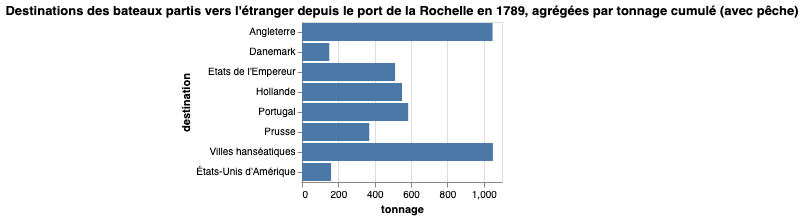

In [15]:
# =================================================
# =================================================
# select flows from navigo 1789 - port = 'La Rochelle'
# =================================================
# =================================================


destinations_navigo = {}
sum_tonnage = 0
sum_travels = 0
with open('../../../data/navigo_all_flows_1789.csv', newline='') as csvfile:
  transformation_map = {
      'Quatre villes hanséatiques': 'Villes hanséatiques',
      'Etats-Unis': 'États-Unis d\'Amérique',
      # 'Etats de l\'Empereur':''
  }
  flows = csv.DictReader(csvfile)
    
  commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
  stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
    

  commodity_id_fields = ['commodity_id', 'commodity_id2', 'commodity_id3', 'commodity_id4']
  fishing_commodities_ids = set(['00000012','00000240','00000240','00000280','00000306','00000307','00000328','00000329','00000331','00000332','00000336',])
    
  total_commodities = set()
  for flow in flows:
    # destination = flow['destination_partner_balance_1789']
    destination = flow['destination_partner_balance_1789']
    departure = flow['departure']
#    departure = flow['departure_state_1789_fr']
    if destination in transformation_map:
      destination = transformation_map[destination]
    tonnage = float(flow['tonnage'] or 0)
    if flow['departure_function'] == 'O' \
      and flow['departure_ferme_bureau'] == 'La Rochelle' \
      and destination != '' \
      and destination != 'France' \
      and flow['destination_state_1789_fr'] != 'France' :
      commodities = [flow[field].lower() for field in commodity_fields if flow[field] != '']
      not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
        
      peche_ids = [commodity for commodity in commodities_ids if commodity in fishing_commodities_ids]
      # take the flow if no commodity specified or at least one 'not stop' commodity speciied
      # if len(commodities) == 0 or (len(not_stop) > 0 and len(peche_ids) == 0):
      if len(commodities) == 0 or len(not_stop) > 0:
        for c in not_stop:
          total_commodities.add(c)
        # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
        # at this point we have all the flows we want
        if destination not in destinations_navigo:
          destinations_navigo[destination] = 0
        destinations_navigo[destination] += tonnage
        sum_tonnage += tonnage
        sum_travels += 1
print('Destinations selon navigo (en tonneaux) : ')
print(pds.DataFrame([{"destination": destination, "tonnage": tonnage} for destination, tonnage in destinations_navigo.items()]))
print('Tonnage moyen des navires : ' + str(sum_tonnage / sum_travels))

VegaLite({
    "title": "Destinations des bateaux partis vers l'étranger depuis le port de la Rochelle en 1789, agrégées par tonnage cumulé (avec pêche)",
    "data": {
        "values": [{"destination": destination, "tonnage": tonnage} for destination, tonnage in destinations_navigo.items()]
    },
    "mark": {"type": "bar", "tooltip": True},
      "encoding": {
        "y": {
            "field": "destination", 
            "type": "nominal",
            "title": "destination"
        },
        "x": {
            "field": "tonnage",
            "type": "quantitative"
        }
      }
})

Destinations selon navigo (en tonneaux) : 
             destination  tonnage
0    Villes hanséatiques   1050.0
1             Angleterre   1048.0
2    Etats de l'Empereur    512.0
3               Danemark    150.0
4                 Prusse    370.0
5               Hollande    550.0
6  États-Unis d'Amérique    160.0
7               Portugal    584.0
Tonnage moyen des navires : 126.4


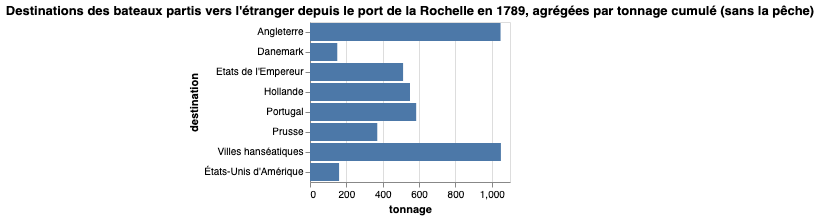

In [16]:
# =================================================
# =================================================
# select flows from navigo 1789 - port = 'La Rochelle' - without pêche
# =================================================
# =================================================


destinations_navigo = {}
sum_tonnage = 0
sum_travels = 0
with open('../../../data/navigo_all_flows_1789.csv', newline='') as csvfile:
  transformation_map = {
      'Quatre villes hanséatiques': 'Villes hanséatiques',
      'Etats-Unis': 'États-Unis d\'Amérique',
      # 'Etats de l\'Empereur':''
  }
  flows = csv.DictReader(csvfile)
  commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
  stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
    
  commodity_id_fields = ['commodity_id', 'commodity_id2', 'commodity_id3', 'commodity_id4']
  fishing_commodities_ids = set(['00000012','00000240','00000240','00000280','00000306','00000307','00000328','00000329','00000331','00000332','00000336',])
    
  total_commodities = set()
  for flow in flows:
    # destination = flow['destination_partner_balance_1789']
    destination = flow['destination_partner_balance_1789']
    departure = flow['departure']
#    departure = flow['departure_state_1789_fr']
    if destination in transformation_map:
      destination = transformation_map[destination]
    tonnage = float(flow['tonnage'] or 0)
    if flow['departure_function'] == 'O' \
      and flow['departure_ferme_bureau'] == 'La Rochelle' \
      and destination != '' \
      and destination != 'France' \
      and flow['destination_state_1789_fr'] != 'France' :
      commodities = [flow[field].lower() for field in commodity_fields if flow[field] != '']
      not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
        
      peche_ids = [commodity for commodity in commodities_ids if commodity in fishing_commodities_ids]
      # take the flow if no commodity specified or at least one 'not stop' commodity speciied
      if len(commodities) == 0 or (len(not_stop) > 0 and len(peche_ids) == 0):
        for c in not_stop:
          total_commodities.add(c)
        # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
        # at this point we have all the flows we want
        if destination not in destinations_navigo:
          destinations_navigo[destination] = 0
        destinations_navigo[destination] += tonnage
        sum_tonnage += tonnage
        sum_travels += 1
print('Destinations selon navigo (en tonneaux) : ')
print(pds.DataFrame([{"destination": destination, "tonnage": tonnage} for destination, tonnage in destinations_navigo.items()]))
print('Tonnage moyen des navires : ' + str(sum_tonnage / sum_travels))

VegaLite({
    "title": "Destinations des bateaux partis vers l'étranger depuis le port de la Rochelle en 1789, agrégées par tonnage cumulé (sans la pêche)",
    "data": {
        "values": [{"destination": destination, "tonnage": tonnage} for destination, tonnage in destinations_navigo.items()]
    },
    "mark": {"type": "bar", "tooltip": True},
      "encoding": {
        "y": {
            "field": "destination", 
            "type": "nominal",
            "title": "destination"
        },
        "x": {
            "field": "tonnage",
            "type": "quantitative"
        }
      }
})

On visualise ensuite les flux d'export du bureau des fermes de La Rochelle.

Filtrage des flux toflit18 :

- année : 1789
- customs_office : 'La Rochelle'
- drapeau 'best_guess_region_prodxpart' (flux avec direction des fermes, produit et partenaire)
- export_import : "Exports"
- partner_grouping différent de 'France'
- partner_simplification différent de 'Colonies françaises', 'Îles françaises de l\'Amérique', 'Sénégal', 'Saint-Domingue'


On visualise les valeurs d'export brutes, puis les valeurs d'export pondérées par les ratios terre-mer par partenaire calculé grâce à la source terre-mer.


Ratio : le partenaire suivant n'a pas été trouvé dans les ratios, il sera considéré comme 100% mer :  Monde hors colonies
Ratio : le partenaire suivant n'a pas été trouvé dans les ratios, il sera considéré comme 100% mer :  Indes

Partenaires selon toflit18 (en livre tournois) - non corrigé avec terre-mer : 
            partenaire  valeur exports
0  Monde hors colonies    5.136098e+06
1  Villes hanséatiques    1.064053e+04
2  Etats de l'Empereur    3.343824e+03
3               Prusse    2.776752e+03
4                Indes    3.806000e+04


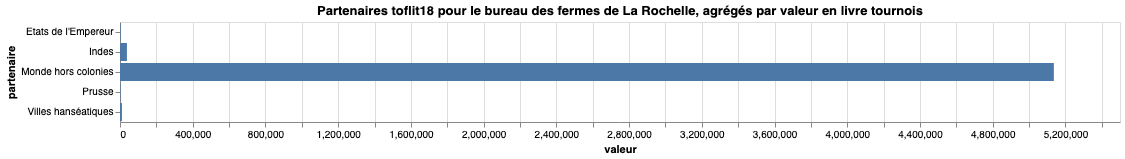


Partenaires selon toflit18 (en livre tournois) - corrigé avec terre-mer : 
            partenaire  valeur exports
0  Monde hors colonies    5.136098e+06
1  Villes hanséatiques    1.064053e+04
2  Etats de l'Empereur    2.172075e+03
3               Prusse    2.776752e+03
4                Indes    3.806000e+04


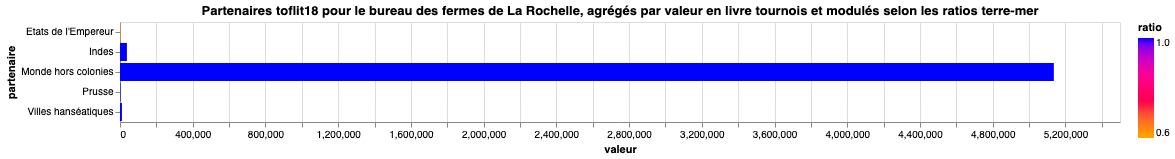

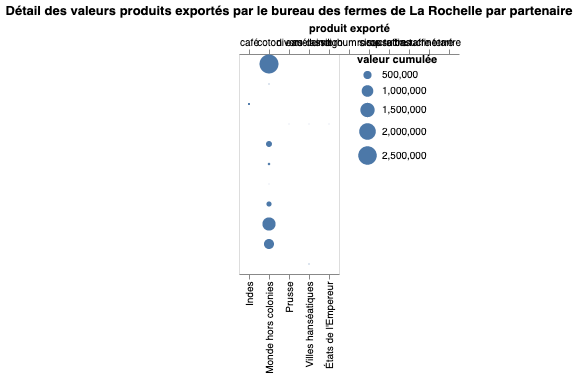

In [17]:
# =================================================
# =================================================
# select flows from  - customs office = 'La Rochelle'
# =================================================
# =================================================

with open('./terre_mer.csv', newline='') as csvfile:
    rows_terremer = list(csv.DictReader(csvfile))

terre_mer_ratio = {}
terre_mer = {}
mer_seule = {}
for row in rows_terremer:
  if row['partner'] not in terre_mer:
    partner = row['partner']
    transformation_map = {
      'Villes Anséatiques': 'Villes hanséatiques',
      'Danemarck et Norwège': 'Danemark',
      'République de Gênes': 'Gênes',
      'Naples et Sicile': 'Naples',
      'États du Roi de Sardaigne': 'Royaume de Sardaigne',
      'Angleterre, Ecosse et Irlande': 'Angleterre',
      'Rome et Venise': 'Venise',
      'États de l\'Empereur, en Flandre et Allemagne': 'Etats de l\'Empereur',
      'Suisse, ses Alliées et Genève': 'Suisse'
    }
    if partner in transformation_map:
      partner = transformation_map[partner]
    terre_mer_ratio[partner] = float(row['ratio_terre_mer'])
    terre_mer[partner] = float(row['somme_mer']) + float(row['somme_terre'])
    mer_seule[partner] = float(row['somme_mer'])

partners_toflit18 = {}
ratios = {}
flows_detail = []
with open('../../../data/toflit18_all_flows.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  for flow in flows:
    # and flow['best_guess_region_prodxpart'] == '1' \
    if flow['year'] == '1789' \
      and flow['customs_office'] == 'La Rochelle' \
      and flow['export_import'] == 'Exports' \
      and flow['partner_simplification'] != 'Îles françaises de l\'Amérique' \
      and flow['partner_simplification'] != 'Colonies françaises' \
      and flow['partner_simplification'] != 'Saint-Domingue' \
      and flow['partner_simplification'] != 'Sénégal' \
      and flow['partner_grouping'] != 'France':
        partner = flow['partner_simplification']
        if partner == 'États de l\'Empereur':
            partner = 'Etats de l\'Empereur'
        value = float(flow['value'] or 0)
        if partner not in partners_toflit18:
         partners_toflit18[partner] = 0
        partners_toflit18[partner] += value
        flows_detail.append(flow)

partners_toflit18_corrected = {}
for (partner, value) in partners_toflit18.items():
  ratio = 1
  
  if partner in terre_mer_ratio:
    ratio = float(terre_mer_ratio[partner])
  else:
    print('Ratio : le partenaire suivant n\'a pas été trouvé dans les ratios, il sera considéré comme 100% mer : ', partner)
  partners_toflit18_corrected[partner] = value * ratio
  ratios[partner] = ratio
    
print()

print('Partenaires selon toflit18 (en livre tournois) - non corrigé avec terre-mer : ' )
print(pds.DataFrame([{"partenaire": partenaire, "valeur exports": valeur} for partenaire, valeur in partners_toflit18.items()]))

VegaLite({
    "title": "Partenaires toflit18 pour le bureau des fermes de La Rochelle, agrégés par valeur en livre tournois",
    "data": {
        "values": [{"partenaire": partenaire, "valeur": valeur} for partenaire, valeur in partners_toflit18.items()]
    },
    "width": 1000,
    "mark": {"type": "bar", "tooltip": True},
      "encoding": {
        "y": {
            "field": "partenaire", 
            "type": "nominal",
            "title": "partenaire"
        },
        "x": {
            "field": "valeur",
            "type": "quantitative"
        }
      }
})
print()
print('Partenaires selon toflit18 (en livre tournois) - corrigé avec terre-mer : ')
print(pds.DataFrame([{"partenaire": partenaire, "valeur exports": valeur} for partenaire, valeur in partners_toflit18_corrected.items()]))

VegaLite({
    "title": "Partenaires toflit18 pour le bureau des fermes de La Rochelle, agrégés par valeur en livre tournois et modulés selon les ratios terre-mer",
    "data": {
        "values": [{"partenaire": partenaire, "valeur": valeur, "ratio": ratios[partenaire] or 0} for partenaire, valeur in partners_toflit18_corrected.items()]
    },
    "width": 1000,
    "mark": {"type": "bar", "tooltip": True},
      "encoding": {
        "y": {
            "field": "partenaire", 
            "type": "nominal",
            "title": "partenaire"
        },
        "x": {
            "field": "valeur",
            "type": "quantitative"
        },
        "color": {
            "field": "ratio",
            "type": "quantitative",
            "scale": {"range": ["orange", "blue"]}
        }
      }
})

VegaLite({
    "title": "Détail des valeurs produits exportés par le bureau des fermes de La Rochelle par partenaire",
    "data": {
        "values": flows_detail
    },
    "mark": {"type": "circle", "tooltip": True},
      "encoding": {
        "x": {
            "field": "partner_simplification",
            "axis": {"title": ""}
        },
        "y": {
            "field": "product_simplification", 
            "type": "nominal",
            "title": "produit exporté",
            "axis": {"orient": "top"}
        },
        "size": {
            "field": "value",
            "title": "valeur cumulée",
            "aggregate": "sum"
        }
      }
})

Première analyse : concernant les flux toflit18 de La Rochelle 1789, les ratios terre-mer n'affectent que légèrement l'Espagne et les Etats de l'Empereur, tous les autres partenaires correspondent à des échanges par mer et ne sont donc pas pondérés.

On compare maintenant les parts relatives des valeurs d'exports toflit18 et des tonnages cumulés navigo par partenaire pour vérifier qu'on ne détecte pas de bizarreries à ce stade avant d'appliquer le modèle :

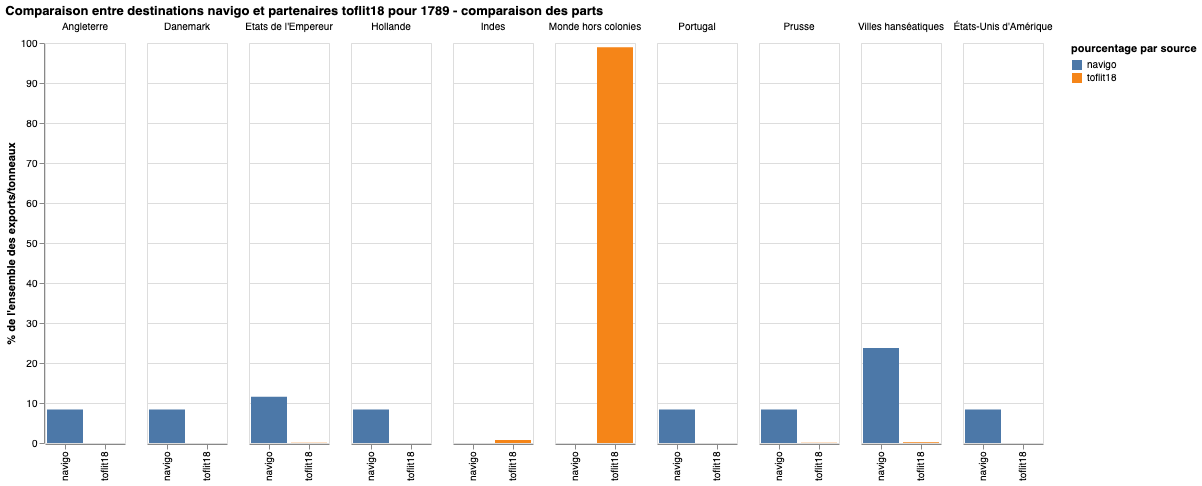

In [18]:
# Compute relative values
def compute_rel_pcts(dct) :
    total = 0
    output = {}
    for key, val in dct.items():
        total += val
    for key, val in dct.items():
        output[key] = val / total * 100
    return output

toflit18_corrected_pcts = compute_rel_pcts(partners_toflit18_corrected)
destinations_navigo_pcts = compute_rel_pcts(destinations_navigo)
correspondances_in_pct = []
navigo_parsed = set()
for key, toflit18_part in toflit18_corrected_pcts.items():
    if key in destinations_navigo_pcts:
        tonnage_part = destinations_navigo_pcts[key]
        navigo_parsed.add(key)
        correspondances_in_pct.append({
            "partner": key,
            "group": "toflit18",
            "value": toflit18_part
        })
        correspondances_in_pct.append({
            "partner": key,
            "group": "navigo",
            "value": tonnage_part
        })
    else: 
        correspondances_in_pct.append({
            "partner": key,
            "group": "toflit18",
            "value": toflit18_part
        })
        correspondances_in_pct.append({
            "partner": key,
            "group": "navigo",
            "value": 0
        })
for key, navigo_part in destinations_navigo_pcts.items():
    if key not in navigo_parsed:
        correspondances_in_pct.append({
            "partner": key,
            "group": "toflit18",
            "value": 0
        })
        correspondances_in_pct.append({
            "partner": key,
            "group": "navigo",
            "value": tonnage_part
        })

VegaLite({
    "title": "Comparaison entre destinations navigo et partenaires toflit18 pour 1789 - comparaison des parts",
    "data": {
        "values": correspondances_in_pct
    },
    "width": 80,
    "height": 400,
    "mark": {"type": "bar", "tooltip": True},
      "encoding": {
        "column": {
            "field": "partner",
            "axis": {"title": ""}
        },
        "y": {
            "field": "value", 
            "type": "quantitative",
            "title": "% de l'ensemble des exports/tonneaux"
        },
        "x": {
            "field": "group",
            "axis": {"title": ""}
        },
        "color": {
            "field": "group",
            "title": "pourcentage par source"
        }
      }
})

Première analyse : à cause de "monde hors colonies" ce graphique ne donne pas grand chose car la plupart des exports toflit18 correspondent à "Monde hors colonies".

Questions :
* pourquoi n'a-t-on aucune navigation vers le Sénégal dans F12 ?
* à quoi devrait correspondre Saint-Domingue dans les destinations navigo ?

### 4.1.2. Test du modèle

On fait maintenant le test en appliquant les prix par tonneau calculés pour la France en 1787 aux destinations du port de La Rochelle en 1789.

On tente d'aggréger les flux toflit18 de la source 'Résumé' puis les pondérer avec les ratios terre-mer, et on calcule le prix par tonneau en se basant sur la source F12 pour ce qui est de la navigation.

On obtient les valeurs d'export en livres tournois suivantes :

Ratio : le partenaire suivant n'a pas été trouvé dans les ratios  Monde hors colonies
Ratio : le partenaire suivant n'a pas été trouvé dans les ratios  Indes
partenaires toflit18 pour la rochelle : 
            partenaire  valeur d'export  valeur d'export pondérée
0  Monde hors colonies     5.136098e+06              5.136098e+06
1  Villes hanséatiques     1.064053e+04              1.064053e+04
2  Etats de l'Empereur     3.343824e+03              2.172075e+03
3               Prusse     2.776752e+03              2.776752e+03
4                Indes     3.806000e+04              3.806000e+04
                      partenaire toflit18 estimation  source/estimation
0                       Danemark        0     28,750                  /
1                     Angleterre        0    622,659                  /
2                         Russie        0          0                  /
3                        Espagne        0          0                  /
4                       Hollande        0    

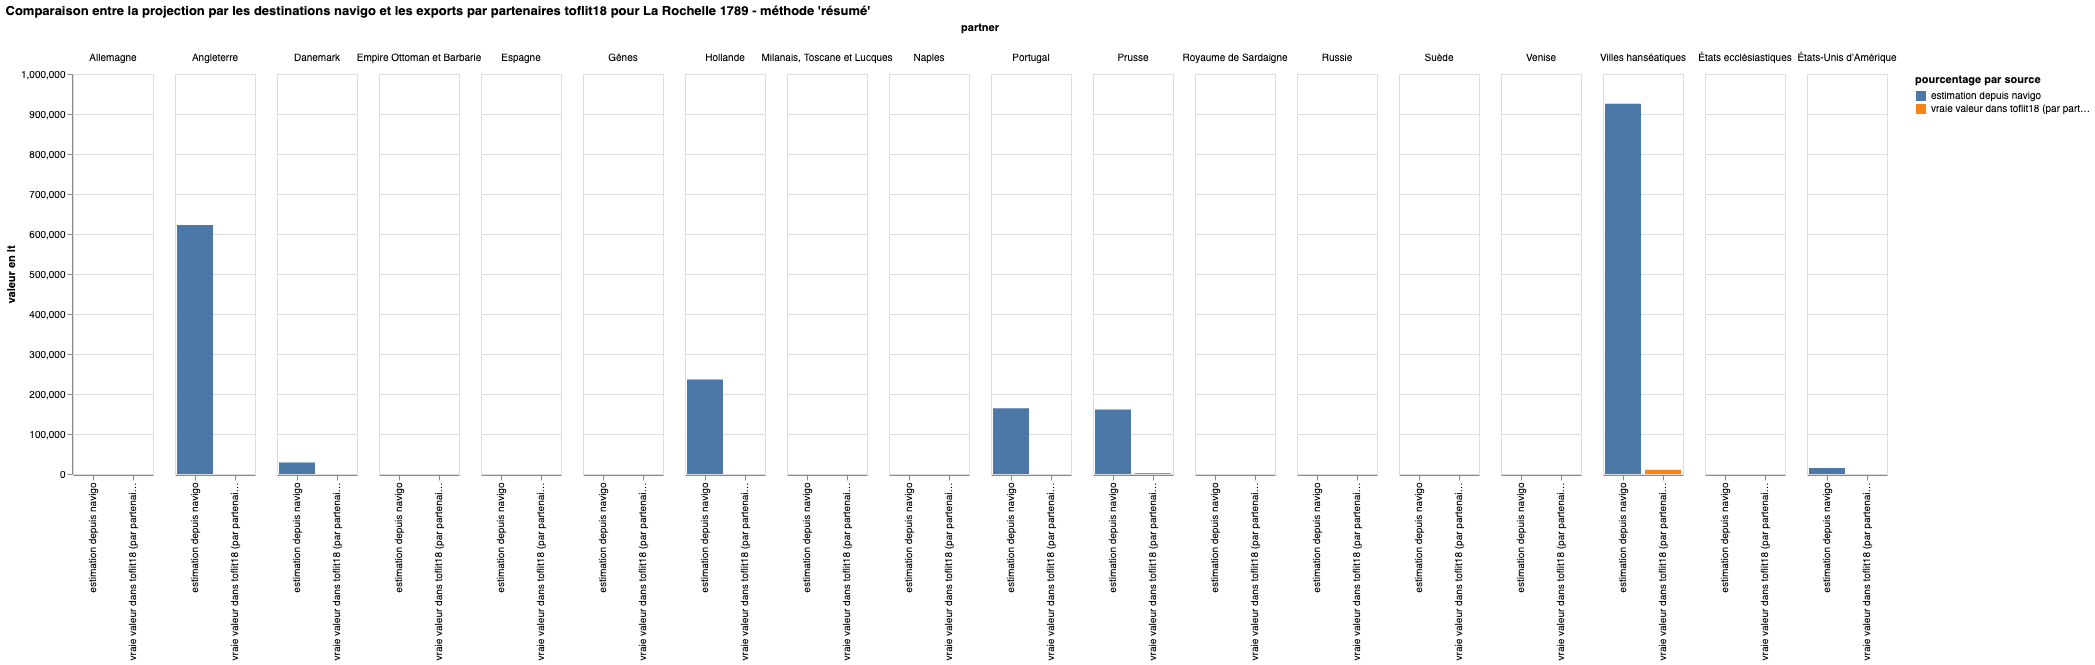

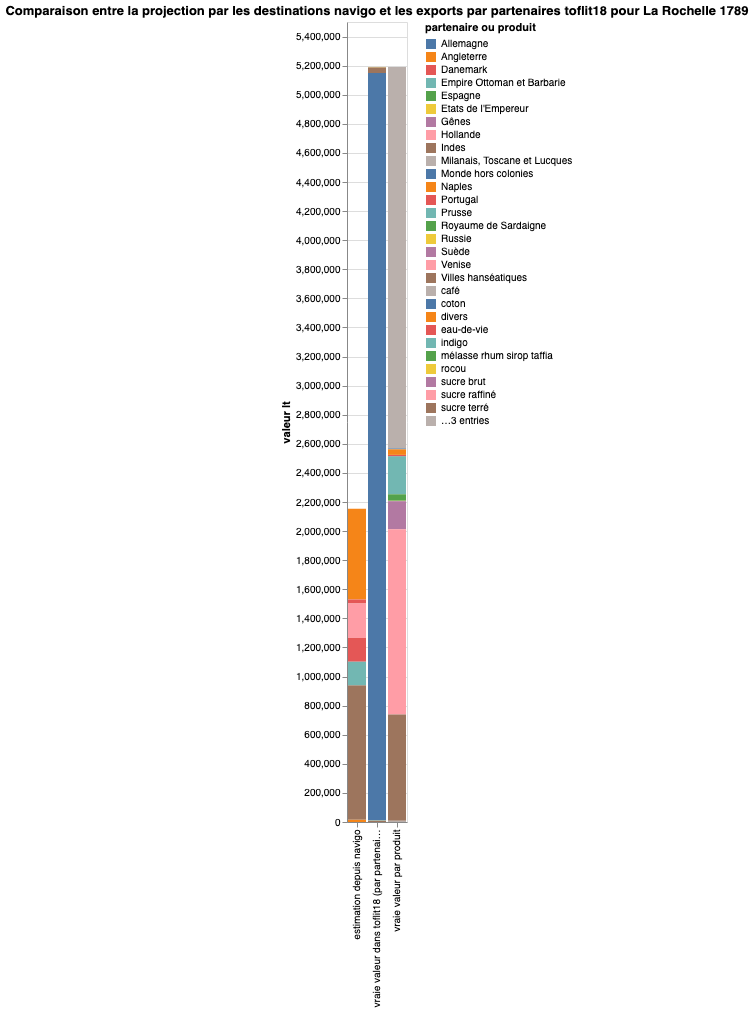

Total des exports en lt selon la projection : 2,153,452
Total des exports en lt selon toflit18 (brut) : 5,190,919
Total des exports en lt selon toflit18 (corrigée) : 5,189,747
rapport projection/réalité : 0.4149435857818172


In [19]:
correspondance, national_ratios = compute_price_per_barrel_per_destination(method="résumé")

# select toflit18 flows for target
partners_toflit18_la_rochelle = {}
ratios = {}
flows_exact = []
with open('../../../data/toflit18_all_flows.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  # and flow['best_guess_region_prodxpart'] == '1' \
  # and flow['partner_simplification'] != 'Îles françaises de l\'Amérique' \
  # and flow['partner_simplification'] != 'Colonies françaises' \
  # and flow['partner_simplification'] != 'Saint-Domingue' \
  # and flow['partner_simplification'] != 'Sénégal' \
  #  and flow['partner_simplification'] != 'Indes' \
  for flow in flows:
    if flow['year'] == '1789' \
      and flow['customs_office'] == 'La Rochelle' \
      and flow['export_import'] == 'Exports' \
      and flow['partner_simplification'] != 'Îles françaises de l\'Amérique' \
      and flow['partner_simplification'] != 'Colonies françaises' \
      and flow['partner_simplification'] != 'Sénégal' \
      and flow['partner_simplification'] != 'Saint-Domingue' \
      and flow['partner_grouping'] != 'France':
        partner = flow['partner_simplification']
        if partner == 'États de l\'Empereur':
            partner = 'Etats de l\'Empereur'
        value = float(flow['value'] or 0)
        if partner not in partners_toflit18_la_rochelle:
         partners_toflit18_la_rochelle[partner] = 0
        partners_toflit18_la_rochelle[partner] += value
        flows_exact.append(flow)

partners_toflit18_la_rochelle_corrected = {}
sum_toflit18_raw = 0
sum_toflit18_corrected = 0

for (partner, value) in partners_toflit18_la_rochelle.items():
  ratio = 1
  
  if partner in national_ratios:
    ratio = float(national_ratios[partner])
  else:
    print('Ratio : le partenaire suivant n\'a pas été trouvé dans les ratios ', partner)
  partners_toflit18_la_rochelle_corrected[partner] = value * ratio
  ratios[partner] = ratio
  sum_toflit18_raw += value
  sum_toflit18_corrected += (value * ratio)
print('partenaires toflit18 pour la rochelle : ')
print(pds.DataFrame([{"partenaire": partenaire, "valeur d'export": valeur, "valeur d'export pondérée": partners_toflit18_la_rochelle_corrected[partenaire]} for partenaire, valeur in partners_toflit18.items()]))
# select navigo flows for La Rochelle
destinations_navigo_la_rochelle = {}
with open('../../../data/navigo_all_flows_1789.csv', newline='') as csvfile:
  transformation_map = {
      'Quatre villes hanséatiques': 'Villes hanséatiques',
      'Etats-Unis': 'États-Unis d\'Amérique',
      # 'Etats de l\'Empereur':''
  }
  flows = csv.DictReader(csvfile)
    
  commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
  stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
    
  commodity_id_fields = ['commodity_id', 'commodity_id2', 'commodity_id3', 'commodity_id4']
  fishing_commodities_ids = set(['00000012','00000240','00000240','00000280','00000306','00000307','00000328','00000329','00000331','00000332','00000336',])
    
  
  total_commodities = set()
  for flow in flows:
    # destination = flow['destination_partner_balance_1789']
    destination = flow['destination_partner_balance_1789']
    departure = flow['departure']
#    departure = flow['departure_state_1789_fr']
    if destination in transformation_map:
      destination = transformation_map[destination]
    tonnage = float(flow['tonnage'] or 0)
        
    if flow['departure_function'] == 'O' \
      and flow['departure_ferme_bureau'] == 'La Rochelle' \
      and destination != '' \
      and destination != 'France' \
      and flow['destination_state_1789_fr'] != 'France' :
      commodities = [flow[field].lower() for field in commodity_fields if flow[field] != '']
      peche_ids = [commodity for commodity in commodities_ids if commodity in fishing_commodities_ids]
      not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
      # take the flow if no commodity specified or at least one 'not stop' commodity speciied
      if len(commodities) == 0 or (len(not_stop) > 0 and len(peche_ids) == 0):
        for c in not_stop:
          total_commodities.add(c)
        # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
        # at this point we have all the flows we want
        if destination not in destinations_navigo_la_rochelle:
          destinations_navigo_la_rochelle[destination] = 0
        destinations_navigo_la_rochelle[destination] += tonnage
# Projection method
projection = []
sum_projection = 0
table = []
handled_toflit18_partners = set()
for cor in correspondance:
    partner = cor['partner']
    price_per_barrel = cor['price_per_barrel']
    estimate = 0
    toflit18_value = 0
    if partner in destinations_navigo_la_rochelle:
        navigo_tonnage = destinations_navigo_la_rochelle[partner]
        estimate = navigo_tonnage * price_per_barrel
        sum_projection += estimate
        projection.append({
            "partner": partner,
            "group": "estimation depuis navigo",
            "value": estimate
        })
    else:
        projection.append({
            "partner": partner,
            "group": "estimation depuis navigo",
            "value": 0
        })
    if partner in partners_toflit18_la_rochelle:
        handled_toflit18_partners.add(partner)
        toflit18_value = partners_toflit18_la_rochelle[partner]
        projection.append({
            "partner": partner,
            "group": "vraie valeur dans toflit18 (par partenaire)",
            "value": toflit18_value
        })
    else:
        projection.append({
            "partner": partner,
            "group": "vraie valeur dans toflit18 (par partenaire)",
            "value": 0
        })
    table.append({
        "partenaire": partner,
        "toflit18": f'{int(toflit18_value):,}',
        "estimation" : f'{int(estimate):,}',
        "source/estimation": str(int(estimate) / int(toflit18_value)) if toflit18_value > 0 else "/"
    })
extra_toflit18 = []
for partner, value in partners_toflit18_la_rochelle.items():
    if partner not in handled_toflit18_partners:
        extra_toflit18.append({
            "partner": partner,
            "group": "vraie valeur dans toflit18 (par partenaire)",
            "value": value
        })

print(pds.DataFrame(table))
        
VegaLite({
    "title": "Comparaison entre la projection par les destinations navigo et les exports par partenaires toflit18 pour La Rochelle 1789 - méthode 'résumé'",
    "data": {
        "values": projection
    },
    "width": 80,
    "height": 400,
    "mark": {"type": "bar", "tooltip": True},
      "encoding": {
        "column": {"field": "partner"},
        "y": {
            "field": "value", 
            "type": "quantitative",
            "title": "valeur en lt"
        },
        "x": {
            "field": "group",
            "axis": {"title": ""}
        },
        "color": {
            "field": "group",
            "title": "pourcentage par source"
        }
      }
})

by_product = {}
for flow in flows_exact:
    product = flow['product_simplification']
    value = float(flow['value'] or 0)
    if product not in by_product:
        by_product[product] = 0
    by_product[product] += value
by_product = [{"partner": product, "group": "vraie valeur par produit", "value": value} for product, value in by_product.items()]

VegaLite({
    "title": "Comparaison entre la projection par les destinations navigo et les exports par partenaires toflit18 pour La Rochelle 1789",
    "data": {
        "values": projection + extra_toflit18 + by_product
    },
    "mark": {"type": "bar", "tooltip": True},
    "height": 800,
      "encoding": {
        "y": {
            "field": "value", 
            "type": "quantitative",
            "title": "valeur lt"
        },
        "x": {
            "field": "group",
            "axis": {"title": ""},
            "sort": {"order": "ascending", "field": "y"}
        },
        "color": {
            "field": "partner",
            "title": "partenaire ou produit"
        }
      }
})

print("Total des exports en lt selon la projection : " + f'{int(sum_projection):,}')
print("Total des exports en lt selon toflit18 (brut) : " + f'{int(sum_toflit18_raw):,}')
print("Total des exports en lt selon toflit18 (corrigée) : " + f'{int(sum_toflit18_corrected):,}')
print('rapport projection/réalité : ' + str(sum_projection / sum_toflit18_corrected))

Première analyse : 

* les comparaisons par destinations ne donnent rien à cause de "monde hors colonies"
* la projection globale sous-estime de 2 fois les exports tels que décrits par toflit18.

On suppose que la différence est due au fait que le café et le sucre sont largement surreprésentés dans les exports de La Rochelle.

Éprouvons maintenant la méthode en refaisant le test avec d'autres ports/bureaux de ferme.

In [20]:

def project_for_bureau (ferme_bureau, ferme_key = 'departure_ferme_bureau'):
  # build two models
  correspondance_resume, national_ratios = compute_price_per_barrel_per_destination(method='résumé')

  # =================================================
  # =================================================
  # select flows from navigo 1787 - ferme_bureau = ferme_bureau
  # =================================================
  # =================================================
  destinations_navigo = {}
  sum_tonnage = 0
  sum_travels = 0
  ports = set()
  with open('../../../data/navigo_all_flows_1789.csv', newline='') as csvfile:
    transformation_map = {
        'Quatre villes hanséatiques': 'Villes hanséatiques',
        'Etats-Unis': 'États-Unis d\'Amérique',
        # 'Etats de l\'Empereur':''
    }
    flows = csv.DictReader(csvfile)
    
    commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
    stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
    
    commodity_id_fields = ['commodity_id', 'commodity_id2', 'commodity_id3', 'commodity_id4']
    fishing_commodities_ids = set(['00000012','00000240','00000240','00000280','00000306','00000307','00000328','00000329','00000331','00000332','00000336',])
    
    
    total_commodities = set()
    for flow in flows:
      destination = flow['destination_partner_balance_1789']
      departure = flow['departure']
      bureau_clean = flow[ferme_key]
      if bureau_clean == 'Charente':
            bureau_clean = 'Tonnay-Charente'
      if bureau_clean == 'Saint-Martin île de Ré':
            bureau_clean = 'Saint-Martin-de-Ré'
      if destination in transformation_map:
        destination = transformation_map[destination]
      tonnage = float(flow['tonnage'] or 0)
      if flow['departure_function'] == 'O' \
        and bureau_clean == ferme_bureau \
        and destination != '' \
        and destination != 'France' \
        and flow['destination_state_1789_fr'] != 'France' :
        ports.add(departure)
        commodities = [flow[field].lower() for field in commodity_fields if flow[field] != '']
        peche_ids = [commodity for commodity in commodities_ids if commodity in fishing_commodities_ids]
        not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
        # take the flow if no commodity specified or at least one 'not stop' commodity speciied
        if len(commodities) == 0 or (len(not_stop) > 0 and len(peche_ids) == 0):
          for c in not_stop:
            total_commodities.add(c)
          # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
          # at this point we have all the flows we want
          if destination not in destinations_navigo:
            destinations_navigo[destination] = 0
          destinations_navigo[destination] += tonnage
          sum_tonnage +=  tonnage
          sum_travels += 1
  print('Destinations selon navigo (en tonneaux) : ')
  print(pds.DataFrame([{"destination": destination, "tonnage": tonnage} for destination, tonnage in destinations_navigo.items()]))
  print('Ports pris en compte pour le bureau : ' + ', '.join(list(ports)))
  print('Tonnage moyen des navires : ' + str(sum_tonnage / sum_travels))

  VegaLite({
      "title": "Destinations des bateaux partis vers l'étranger depuis le ou les ports associés " + ("au bureau des fermes" if ferme_key == 'departure_ferme_bureau' else "à la direction des fermes") + " de " + ferme_bureau + " en 1789, agrégées par tonnage cumulé",
      "width": 1000,
      "data": {
          "values": [{"destination": destination, "tonnage": tonnage} for destination, tonnage in destinations_navigo.items()]
      },
      "mark": {"type": "bar", "tooltip": True},
        "encoding": {
          "y": {
              "field": "destination", 
              "type": "nominal",
              "title": "destination"
          },
          "x": {
              "field": "tonnage",
              "type": "quantitative"
          }
        }
  })

  # =================================================
  # =================================================
  # select flows from  - customs office = ferme_bureau
  # =================================================
  # =================================================

  partners_toflit18 = {}
  sum_toflit18_raw = 0
  flows_detail = []
  print('scan des valeurs pour ' + ('le bureau des fermes de ' if ferme_key == 'departure_ferme_bureau' else 'la direction des fermes de ') + ferme_bureau)
  with open('../../../data/toflit18_all_flows.csv', newline='') as csvfile:
    flows = csv.DictReader(csvfile)
    for flow in flows:
      if flow['year'] == '1789' \
        and flow['customs_office' if ferme_key == 'departure_ferme_bureau' else 'customs_region'] == ferme_bureau \
        and flow['export_import'] == 'Exports' \
        and flow['partner_simplification'] != 'Îles françaises de l\'Amérique' \
        and flow['partner_simplification'] != 'Colonies françaises' \
        and flow['partner_grouping'] != 'France':
          partner = flow['partner_simplification']
          if partner == "États de l'Empereur":
            partner = "Etats de l'Empereur"
          value = float(flow['value'] or 0)
          if partner not in partners_toflit18:
            partners_toflit18[partner] = 0
          partners_toflit18[partner] += value
          sum_toflit18_raw += value
          flows_detail.append(flow)
  print('flux bruts toflit18 : ')
  print(pds.DataFrame([{"partenaire": partenaire, "valeur": valeur} for partenaire, valeur in partners_toflit18.items()]))

  partners_toflit18_corrected = {}
  sum_toflit18_corrected = 0
  for (partner, value) in partners_toflit18.items():
    ratio = 1
    
    if partner in national_ratios:
      ratio = float(national_ratios[partner])
    else:
      print('Problème d\'attribution du le partenaire qui n\'est pas dans la table des ratios terre-mer : ', partner)
    partners_toflit18_corrected[partner] = value * ratio
    sum_toflit18_corrected += (value * ratio)

  VegaLite({
      "title": "Partenaires toflit18 pour " + ("le bureau des fermes" if ferme_key == 'departure_ferme_bureau' else 'la direction des fermes') + " de " + ferme_bureau + ", agrégés par valeur en livre tournois",
      "data": {
          "values": [{"partenaire": partenaire, "valeur": valeur} for partenaire, valeur in partners_toflit18.items()]
      },
      "width": 1000,
      "mark": {"type": "bar", "tooltip": True},
        "encoding": {
          "y": {
              "field": "partenaire", 
              "type": "nominal",
              "title": "partenaire"
          },
          "x": {
              "field": "valeur",
              "type": "quantitative"
          }
        }
  })
  VegaLite({
      "title": "Partenaires toflit18 pour " + ("le bureau des fermes" if ferme_key == 'departure_ferme_bureau' else 'la direction des fermes') + " de " + ferme_bureau + ", agrégés par valeur en livre tournois et modulés selon les ratios terre-mer",
      "data": {
          "values": [{"partenaire": partenaire, "valeur": valeur, "ratio": national_ratios[partenaire] if partenaire in national_ratios else 1} for partenaire, valeur in partners_toflit18_corrected.items()]
      },
      "width": 1000,
      "mark": {"type": "bar", "tooltip": True},
        "encoding": {
          "y": {
              "field": "partenaire", 
              "type": "nominal",
              "title": "partenaire"
          },
          "x": {
              "field": "valeur",
              "type": "quantitative"
          },
          "color": {
              "type": "quantitative",
              "field": "ratio"
          }
        }
  })
    
  VegaLite({
    "title": "Détail des valeurs produits exportés par " + ("le bureau des fermes" if ferme_key == 'departure_ferme_bureau' else 'la direction des fermes') + " de " + ferme_bureau + " par partenaire",
    "data": {
        "values": flows_detail
    },
    "mark": {"type": "rect", "tooltip": True},
      "encoding": {
        "x": {
            "field": "partner_simplification",
            "axis": {"title": "", "orient": "top"},
            "sort": {"field": "-y"}
        },
        "y": {
            "field": "product_revolutionempire", 
            "type": "nominal",
            "title": "produit exporté (revolution & empire)",
            "sort": {"field": "-x"}
        },
        "color": {
            "field": "value",
            "title": "valeur cumulée",
            "aggregate": "sum"
        }
      }
  })

  # Compute relative values
  def compute_rel_pcts(dct) :
      total = 0
      output = {}
      for key, val in dct.items():
          total += val
      for key, val in dct.items():
          output[key] = val / total * 100
      return output

  toflit18_corrected_pcts = compute_rel_pcts(partners_toflit18_corrected)
  destinations_navigo_pcts = compute_rel_pcts(destinations_navigo)
  correspondances_in_pct = []
  navigo_parsed = set()
  for key, toflit18_part in toflit18_corrected_pcts.items():
      if key in destinations_navigo_pcts:
          tonnage_part = destinations_navigo_pcts[key]
          navigo_parsed.add(key)
          correspondances_in_pct.append({
              "partner": key,
              "group": "toflit18",
              "value": toflit18_part
          })
          correspondances_in_pct.append({
              "partner": key,
              "group": "navigo",
              "value": tonnage_part
          })
      else: 
          correspondances_in_pct.append({
              "partner": key,
              "group": "toflit18",
              "value": toflit18_part
          })
          correspondances_in_pct.append({
              "partner": key,
              "group": "navigo",
              "value": 0
          })
  for key, navigo_part in destinations_navigo_pcts.items():
      if key not in navigo_parsed:
          correspondances_in_pct.append({
              "partner": key,
              "group": "toflit18",
              "value": 0
          })
          correspondances_in_pct.append({
              "partner": key,
              "group": "navigo",
              "value": tonnage_part
          })

  VegaLite({
      "title": "Comparaison entre destinations navigo et partenaires toflit18 pour " + ("le bureau" if ferme_key == 'departure_ferme_bureau' else "la direction") + " et port(s) de " + ferme_bureau + " en 1789 - comparaison des parts",
      "data": {
          "values": correspondances_in_pct
      },
      "width": 80,
      "mark": {"type": "bar", "tooltip": True},
        "encoding": {
          "column": {
              "field": "partner",
              "axis": {"title": ""}
          },
          "y": {
              "field": "value", 
              "type": "quantitative",
              "title": "% de l'ensemble des exports/tonneaux"
          },
          "x": {
              "field": "group",
              "axis": {"title": ""}
          },
          "color": {
              "field": "group",
              "title": "pourcentage par source"
          }
        }
  })

  projection_resume = []
  sum_projection_resume = 0
  sum_toflit18_resume = 0
  handled_toflit18_partners = set()
  for cor in correspondance_resume:
      partner = cor['partner']
      price_per_barrel = cor['price_per_barrel']
      if partner in destinations_navigo:
          navigo_tonnage = destinations_navigo[partner]
          estimate = navigo_tonnage * price_per_barrel
          #if partner == 'Danemark':
          #  print('in partner danemark')
          #  print('tonnage (should be 4277) : ', navigo_tonnage)
          #  print('price per barel (should be 230 : ', price_per_barrel)
          #  print('estimate : ', estimate)
          projection_resume.append({
              "partner": partner,
              "group": "estimation depuis navigo",
              "value": estimate
          })
          sum_projection_resume += estimate
      else:
          projection_resume.append({
              "partner": partner,
              "group": "estimation depuis navigo",
              "value": 0
          })
          
      if partner in partners_toflit18_corrected:
          toflit18_value_corrected = partners_toflit18_corrected[partner]
          projection_resume.append({
              "partner": partner,
              "group": "vraie valeur dans toflit18 (pondéré avec terre-mer)",
              "value": toflit18_value_corrected
          })
          projection_resume.append({
              "partner": partner,
              "group": "vraie valeur dans toflit18 (non pondéré)",
              "value": partners_toflit18[partner]
          })
          sum_toflit18_resume += toflit18_value_corrected
          handled_toflit18_partners.add(partner)
      else:
          projection_resume.append({
              "partner": partner,
              "group": "vraie valeur dans toflit18 (non pondéré)",
              "value": 0
          })
  print('Correspondance résumé : ')
  print(pds.DataFrame(correspondance_resume))
            
  VegaLite({
      "title": "Comparaison entre la projection par les destinations navigo et les exports par partenaires toflit18 pour le(s) port(s) associé(s) à " + ferme_bureau + " 1789 - projection 'résumé'",
      "data": {
          "values": projection_resume
      },
      "width": 80,
      "mark": {"type": "bar", "tooltip": True},
        "encoding": {
          "column": {"field": "partner"},
          "y": {
              "field": "value", 
              "type": "quantitative",
              "title": "valeur en lt"
          },
          "x": {
              "field": "group",
              "axis": {"title": ""}
          },
          "color": {
              "field": "group",
              "title": "pourcentage par source"
          }
        }
  })
  
  print("Total des exports en lt selon la projection 'résumé' : " + f'{int(sum_projection_resume):,}' + " lt")
  print("Total des exports en lt selon toflit18 : " + f'{int(sum_toflit18_raw):,}' + " lt")
  print("Total des exports en lt selon toflit18 (corrigé avec ratios terre-mer) : " + f'{int(sum_toflit18_corrected):,}' + " lt")
  print('Méthode \'résumé\' - rapport projection/réalité : facteur de ' + str(sum_projection_resume / sum_toflit18_corrected))

# project_for_bureau('La Rochelle', ferme_key='departure_ferme_direction')

## 4.2. Test sur les ports du bureau des fermes de Saint-Martin-de-Ré

Destinations selon navigo (en tonneaux) : 
             destination  tonnage
0  États-Unis d'Amérique   2227.0
1               Danemark   4277.0
2             Angleterre   3942.0
3                Espagne    297.0
4               Hollande   2463.0
5    Villes hanséatiques   1815.0
6    Etats de l'Empereur    150.0
7                 Prusse   1000.0
8                 Russie    176.0
Ports pris en compte pour le bureau : Saint Martin de Ré, Ars en Ré, La Flotte en Ré
Tonnage moyen des navires : 124.78625954198473


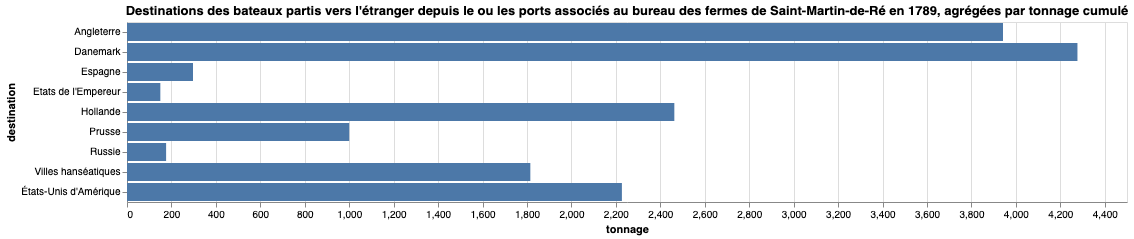

scan des valeurs pour le bureau des fermes de Saint-Martin-de-Ré
flux bruts toflit18 : 
              partenaire         valeur
0             Angleterre   56529.897897
1               Hollande   41338.311326
2    Villes hanséatiques  110739.077552
3               Danemark  201724.816482
4  États-Unis d'Amérique   47357.640000
5                 Prusse   16788.863897
6                 Russie   23034.000000
7                Espagne    5500.799809
8    Etats de l'Empereur     575.135951
9                  Suède    6009.983503


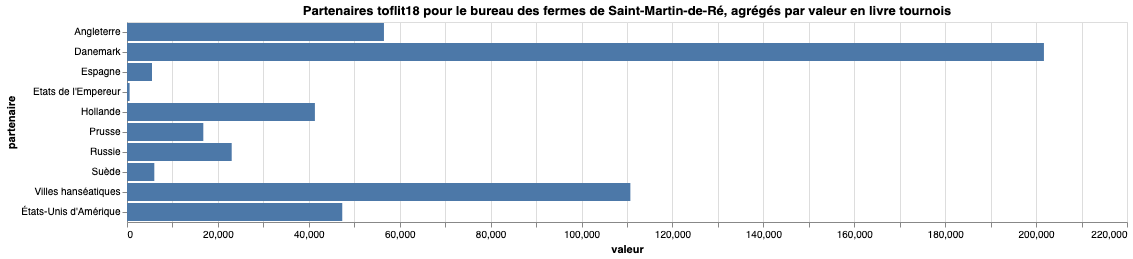

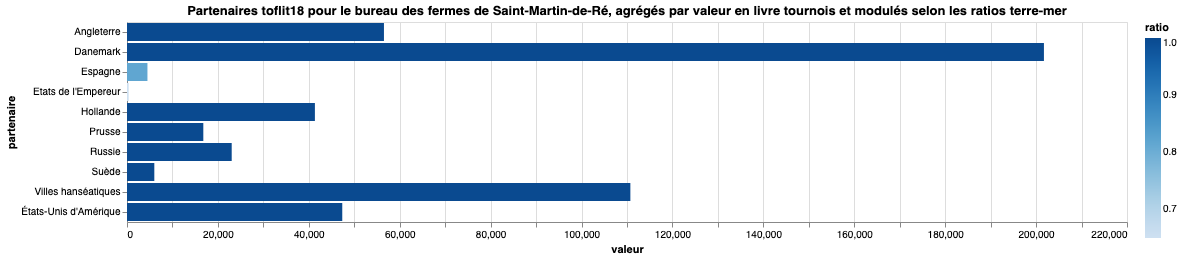

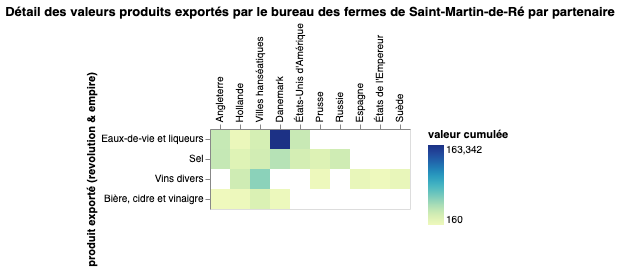

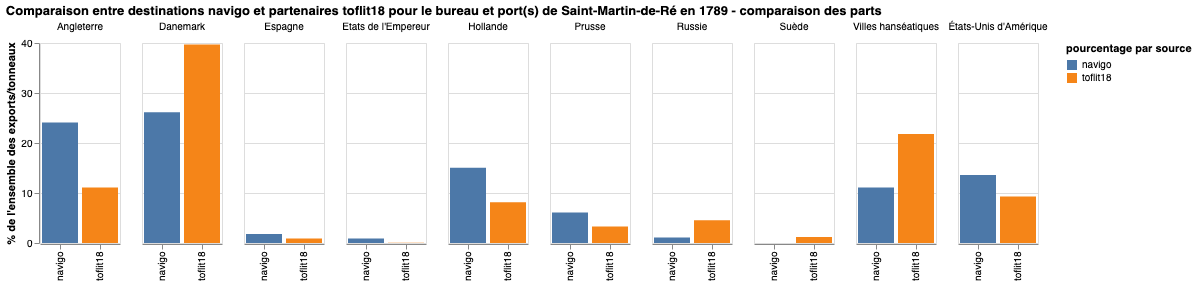

Correspondance résumé : 
                         partner  sum_tonnage   sum_exports  price_per_barrel
0                       Danemark      33049.0  6.334500e+06        191.669945
1                     Angleterre      57563.0  3.420050e+07        594.140333
2                         Russie      14848.0  6.630000e+06        446.524784
3                        Espagne      59250.0  3.283826e+07        554.232315
4                       Hollande      78214.0  3.357150e+07        429.226225
5                       Portugal      14007.0  3.935200e+06        280.945242
6            Villes hanséatiques      68277.0  6.019470e+07        881.624852
7                          Suède      14161.0  5.053700e+06        356.874515
8          États-Unis d'Amérique      22271.0  2.050600e+06         92.074896
9                      Allemagne      28703.0  2.246440e+07        782.649897
10                        Prusse      20644.0  9.008500e+06        436.373765
11          Royaume de Sardaigne      1

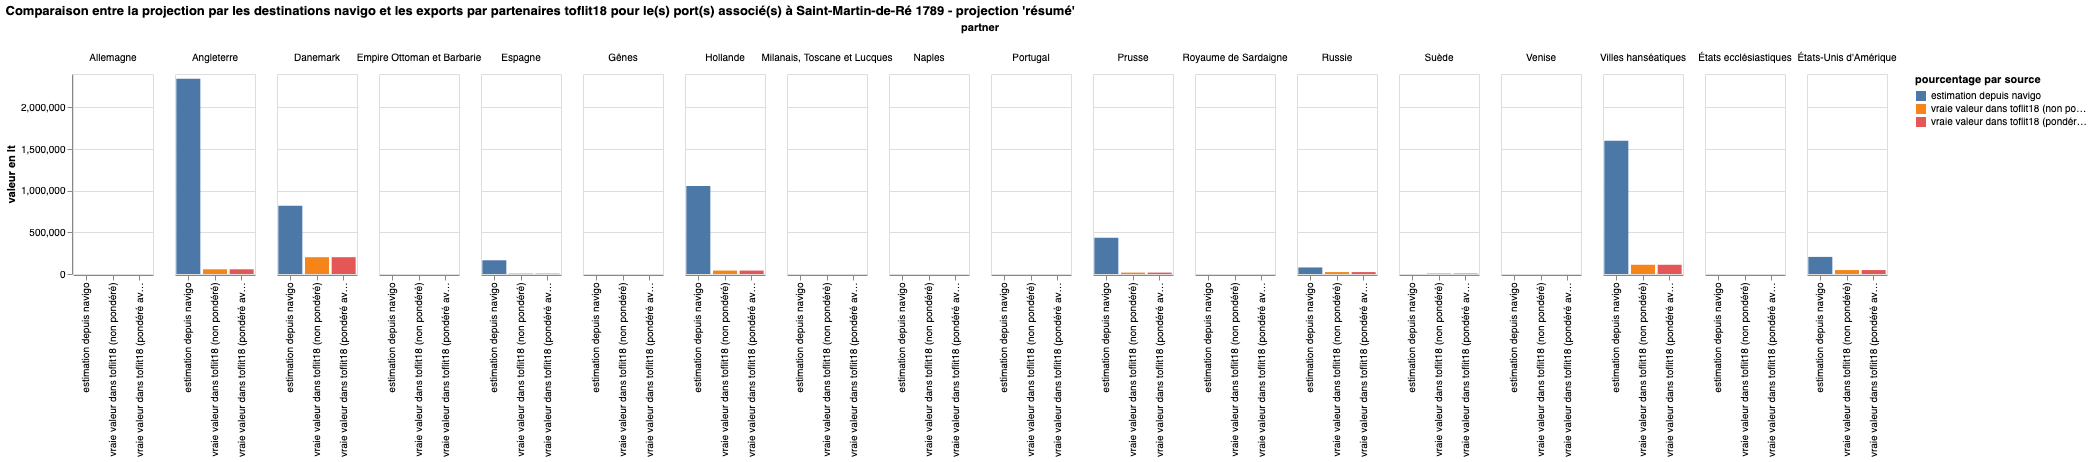

Total des exports en lt selon la projection 'résumé' : 6,703,826 lt
Total des exports en lt selon toflit18 : 509,598 lt
Total des exports en lt selon toflit18 (corrigé avec ratios terre-mer) : 508,393 lt
Méthode 'résumé' - rapport projection/réalité : facteur de 13.186282783547941


In [21]:
project_for_bureau('Saint-Martin-de-Ré')

Première analyse : la projection surestime la valeur des exports de 13 fois, ce n'est pas satisfaisant. Le résultat est étrange, car quand on détaille par partenaire, il semble y avoir une relation de proportionnalité entre la projection et les exports effectifs, mais systématiquement environ 10 fois plus grande.

Hypothèses d'explication :

* ces ports commercent des produits de bien plus faible valeur que la moyenne française. Ou les bateaux partent très peu chargés.
* étant donné d'une part que les bateaux qui partent de ces ports ont des tonnages importants, et d'autre part qu'on les suppose toujours pleins, on surestime la valeur.


NB : dans l'itération précédente de ce travail, on était à 22 fois plus, il y a donc du mieux !

On fait l'hypothèse que la grande différence de ratio par rapport à la projection est dûe au sel. On va donc représenter les produits par poids (on prend également les litres en supposant que les liquides ont un poids similaire à l'eau).

nombre de flux pour le bureau des fermes de Saint-Martin-de-Ré :  25
nombre de flux avec poids :  25
représentativité en nombre de flux : 100.0%


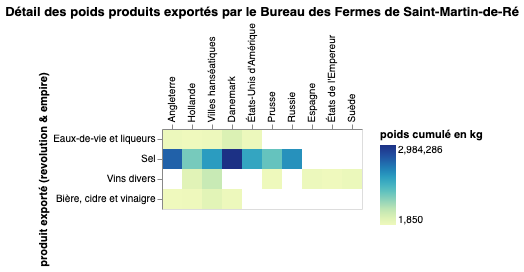

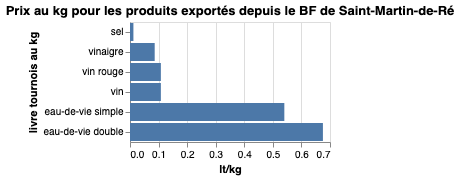

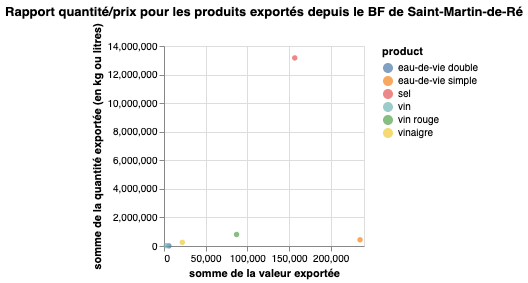

In [46]:
total_nb_flows = 0
nb_flows_with_poids = 0
selected_flows = []
products_data = {}
with open('../../../data/toflit18_all_flows.csv', newline='') as csvfile:
    flows = csv.DictReader(csvfile)
    for flow in flows:
      if flow['year'] == '1789' \
        and flow['customs_office'] == 'Saint-Martin-de-Ré' \
        and flow['export_import'] == 'Exports' \
        and flow['partner_simplification'] != 'Îles françaises de l\'Amérique' \
        and flow['partner_simplification'] != 'Colonies françaises' \
        and flow['partner_grouping'] != 'France':
          partner = flow['partner_simplification']
          if partner == "États de l'Empereur":
            partner = "Etats de l'Empereur"
          value = float(flow['value'] or 0)
          total_nb_flows += 1
          product = flow['product_simplification']
          quantity = flow['quantities_metric']
          quantity_unit = flow['quantity_unit_metric']
          if quantity != '' and (quantity_unit == 'kg' or quantity_unit == 'litres'):
            quantity = float(quantity or 0)
            nb_flows_with_poids += 1
            selected_flows.append(flow)
            if product not in products_data:
                products_data[product] = {
                    "sum_value": 0,
                    "sum_quantity": 0
                }
            products_data[product]['sum_value'] += value
            products_data[product]['sum_quantity'] += quantity
print('nombre de flux pour le bureau des fermes de Saint-Martin-de-Ré : ', total_nb_flows)
print('nombre de flux avec poids : ', nb_flows_with_poids)
print('représentativité en nombre de flux : ' + str((nb_flows_with_poids / total_nb_flows) * 100) + '%')

VegaLite({
"title": "Détail des poids produits exportés par le Bureau des Fermes de Saint-Martin-de-Ré",
"data": {
    "values": selected_flows
},
"mark": {"type": "rect", "tooltip": True},
  "encoding": {
    "x": {
        "field": "partner_simplification",
        "axis": {"title": "", "orient": "top"},
        "sort": {"field": "-y"}
    },
    "y": {
        "field": "product_revolutionempire", 
        "type": "nominal",
        "title": "produit exporté (revolution & empire)",
        "sort": {"field": "-x"}
    },
    "color": {
        "field": "quantities_metric",
        "title": "poids cumulé en kg",
        "aggregate": "sum"
    }
  }
})

products_data = [{
    "product": product, 
    "lt/kg": values["sum_value"] / values["sum_quantity"],
    "sum_value": values["sum_value"],
    "sum_quantity": values["sum_quantity"]
} for product, values in products_data.items()];

VegaLite({
"title": "Prix au kg pour les produits exportés depuis le BF de Saint-Martin-de-Ré",
"data": {
    "values": products_data
},
"mark": {"type": "bar", "tooltip": True},
  "encoding": {
    "y": {
        "field": "product",
        "sort": {"field": "lt/kg"},
        "type": "nominal",
        "title": "livre tournois au kg"
    },
    "x": {
        "field": "lt/kg", 
        "type": "quantitative",
    }
  }
})


VegaLite({
"title": "Rapport quantité/prix pour les produits exportés depuis le BF de Saint-Martin-de-Ré",
"data": {
    "values": products_data
},
"mark": {"type": "circle", "tooltip": True},
  "encoding": {
    "y": {
        "field": "sum_quantity",
        "type": "quantitative",
        "title": "somme de la quantité exportée (en kg ou litres)"
    },
    "x": {
        "field": "sum_value", 
        "type": "quantitative",
        "title": "somme de la valeur exportée"
    },
      "color": {
          "field": "product",
          "type": "nominal",
      }
  }
})

Ces visualisations confirment notre hypothèse selon laquelle le commerce du sel est la source de la surestimation produite par la projection.

## 4.2. Test sur le port de Tonnay-Charente

Destinations selon navigo (en tonneaux) : 
           destination  tonnage
0           Angleterre   5541.0
1  Etats de l'Empereur    482.0
2             Hollande     44.0
3             Danemark     98.0
4             Portugal     47.0
Ports pris en compte pour le bureau : Charente
Tonnage moyen des navires : 103.53333333333333


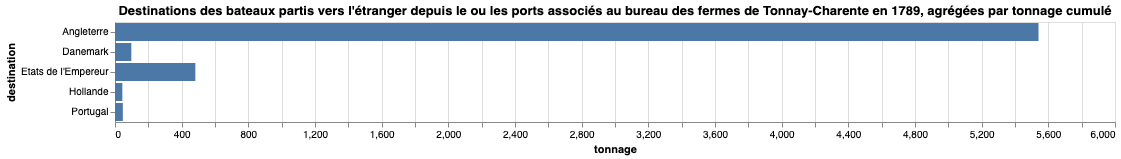

scan des valeurs pour le bureau des fermes de Tonnay-Charente
flux bruts toflit18 : 
            partenaire        valeur
0             Portugal  4.134053e+04
1           Angleterre  4.548521e+06
2             Hollande  1.633188e+04
3  Villes hanséatiques  6.591877e+04
4  Etats de l'Empereur  4.003226e+05
5             Danemark  8.653851e+04


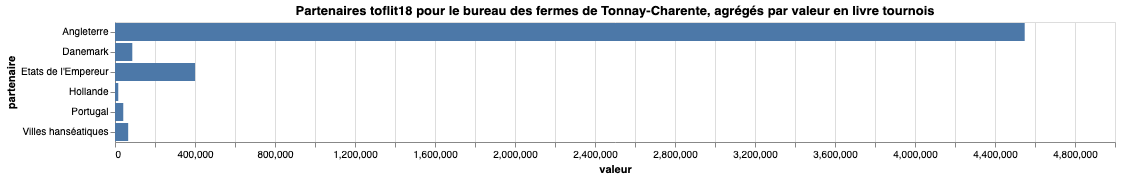

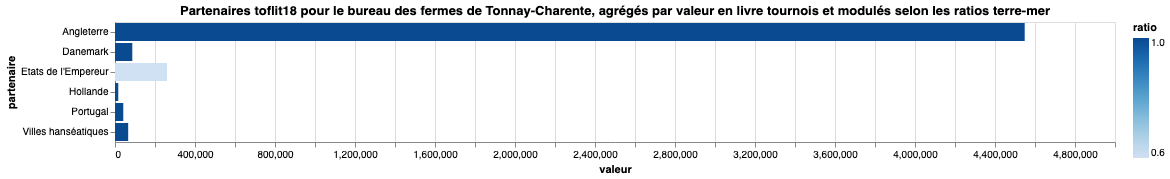

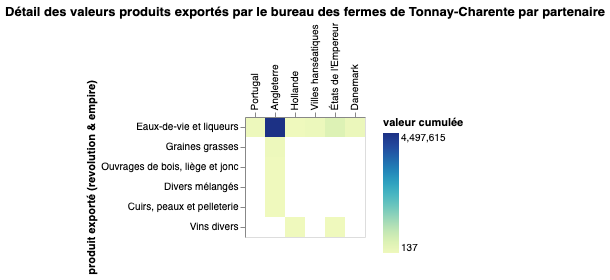

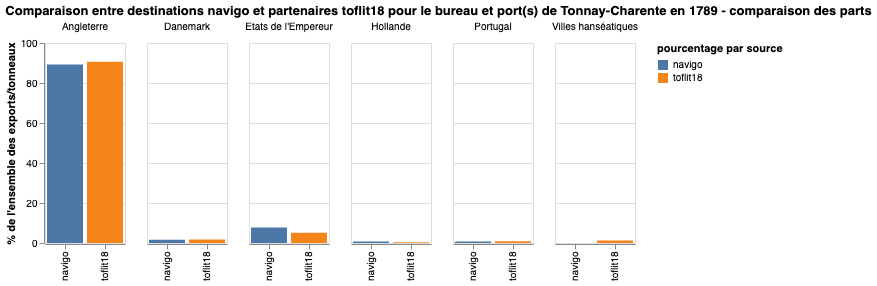

Correspondance résumé : 
                         partner  sum_tonnage   sum_exports  price_per_barrel
0                       Danemark      33049.0  6.334500e+06        191.669945
1                     Angleterre      57563.0  3.420050e+07        594.140333
2                         Russie      14848.0  6.630000e+06        446.524784
3                        Espagne      59250.0  3.283826e+07        554.232315
4                       Hollande      78214.0  3.357150e+07        429.226225
5                       Portugal      14007.0  3.935200e+06        280.945242
6            Villes hanséatiques      68277.0  6.019470e+07        881.624852
7                          Suède      14161.0  5.053700e+06        356.874515
8          États-Unis d'Amérique      22271.0  2.050600e+06         92.074896
9                      Allemagne      28703.0  2.246440e+07        782.649897
10                        Prusse      20644.0  9.008500e+06        436.373765
11          Royaume de Sardaigne      1

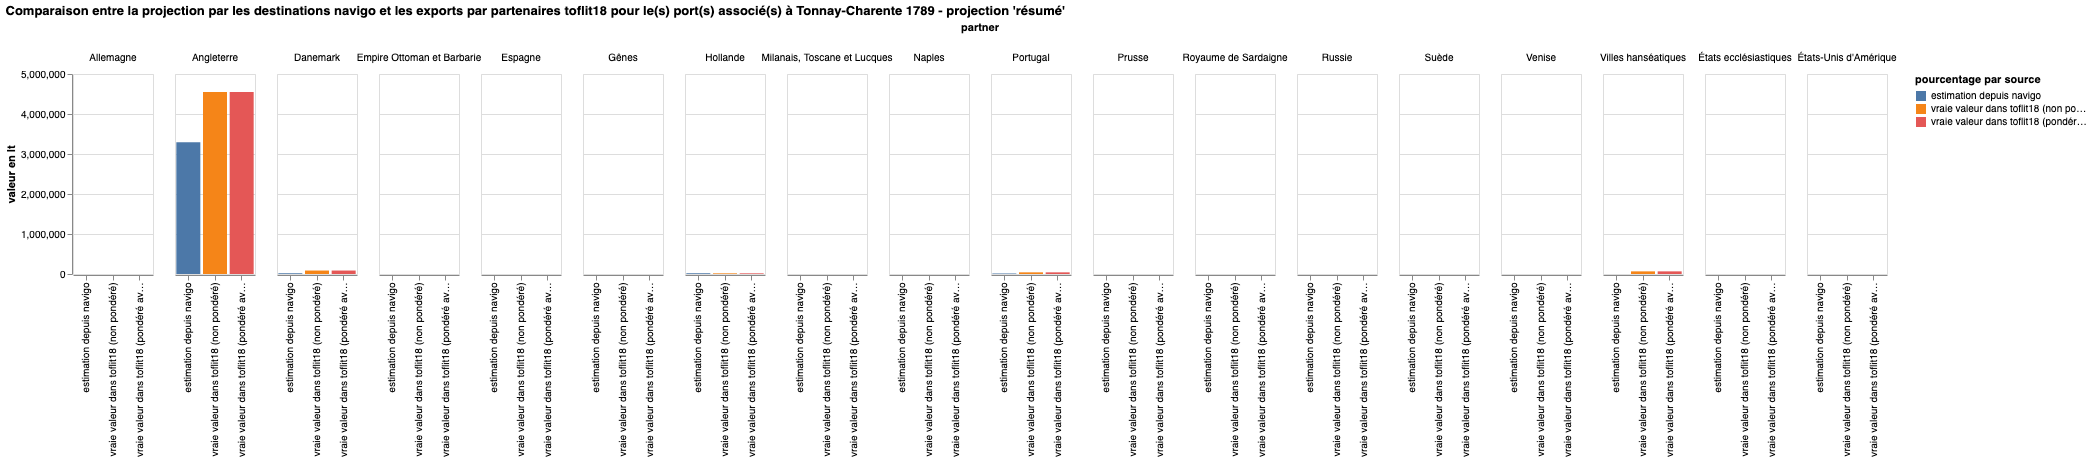

Total des exports en lt selon la projection 'résumé' : 3,343,005 lt
Total des exports en lt selon toflit18 : 5,158,973 lt
Total des exports en lt selon toflit18 (corrigé avec ratios terre-mer) : 5,018,691 lt
Méthode 'résumé' - rapport projection/réalité : facteur de 0.6661110006337072


In [22]:
project_for_bureau('Tonnay-Charente')

Première analyse : les résultats de la projection sont ici plutôt proches de la réalité décrite par toflit18 : elle les sous-estime de 34%.

Hypothèse d'explication :

* l'ensemble des flux de navires concernant Angleterre, on peut supposer que les exports de Tonnay-Charentes correspondent de manière proche au commerce de la France avec la GB en général ?

## 4.3 Test sur la direction des fermes de La Rochelle et tous ses ports associés

Destinations selon navigo (en tonneaux) : 
             destination  tonnage
0             Angleterre  12586.0
1    Etats de l'Empereur   1378.0
2                 Prusse   3696.0
3               Hollande   6639.0
4    Villes hanséatiques   4588.0
5  États-Unis d'Amérique   3038.0
6               Danemark   4915.0
7                Espagne    902.0
8               Portugal   1351.0
9                 Russie    386.0
Ports pris en compte pour le bureau : Saint Martin de Ré, Mortagne, Marennes, Charente, Noirmoutier, Rochefort, Saint Gilles sur Vie, Ars en Ré, La Flotte en Ré, La Rochelle
Tonnage moyen des navires : 129.01633986928104


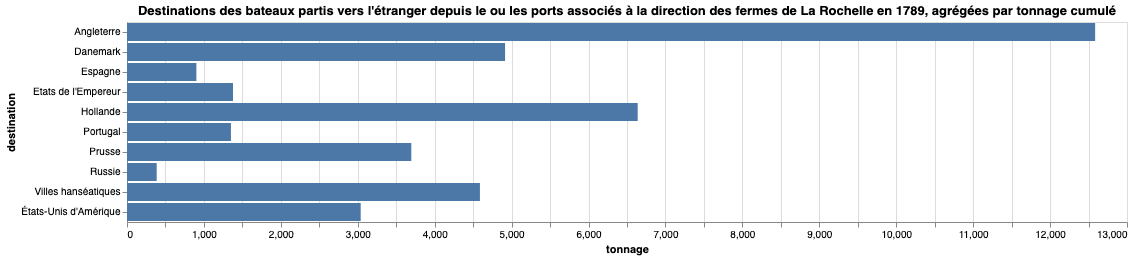

scan des valeurs pour la direction des fermes de La Rochelle
flux bruts toflit18 : 
               partenaire        valeur
0     Monde hors colonies  5.136098e+06
1                 Espagne  3.845865e+04
2              Angleterre  4.881322e+06
3                Portugal  4.134053e+04
4                Hollande  1.615313e+05
5     Villes hanséatiques  5.422232e+05
6     Etats de l'Empereur  4.106972e+05
7                Danemark  2.882633e+05
8                  Prusse  5.127063e+04
9   États-Unis d'Amérique  5.352916e+04
10                 Russie  2.303400e+04
11                  Suède  6.009984e+03
12                Sénégal  1.591040e+06
13         Saint-Domingue  7.141800e+04
14                  Indes  3.806000e+04
Problème d'attribution du le partenaire qui n'est pas dans la table des ratios terre-mer :  Monde hors colonies
Problème d'attribution du le partenaire qui n'est pas dans la table des ratios terre-mer :  Sénégal
Problème d'attribution du le partenaire qui n'est pas dans la ta

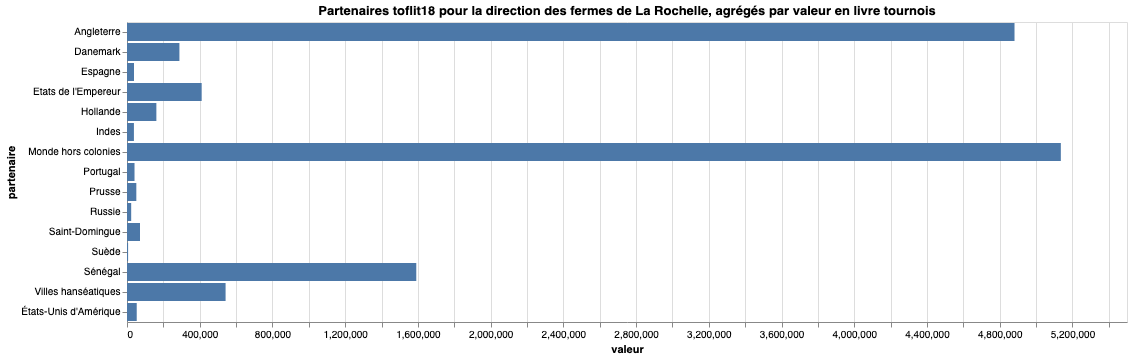

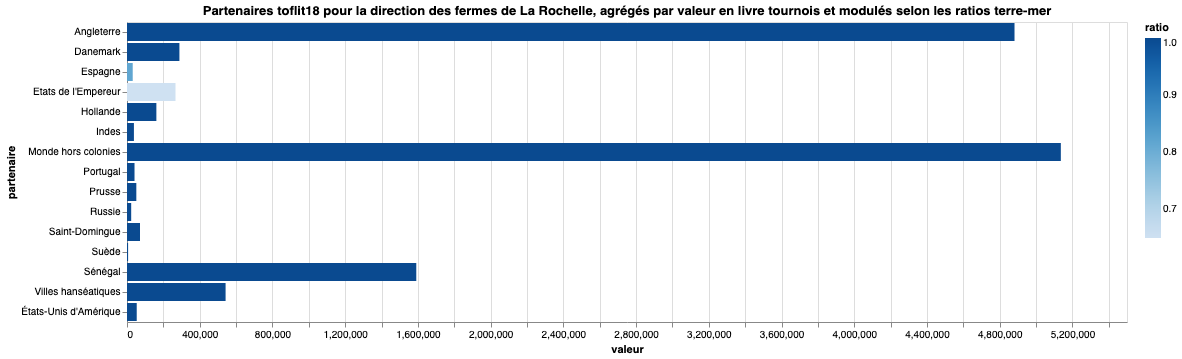

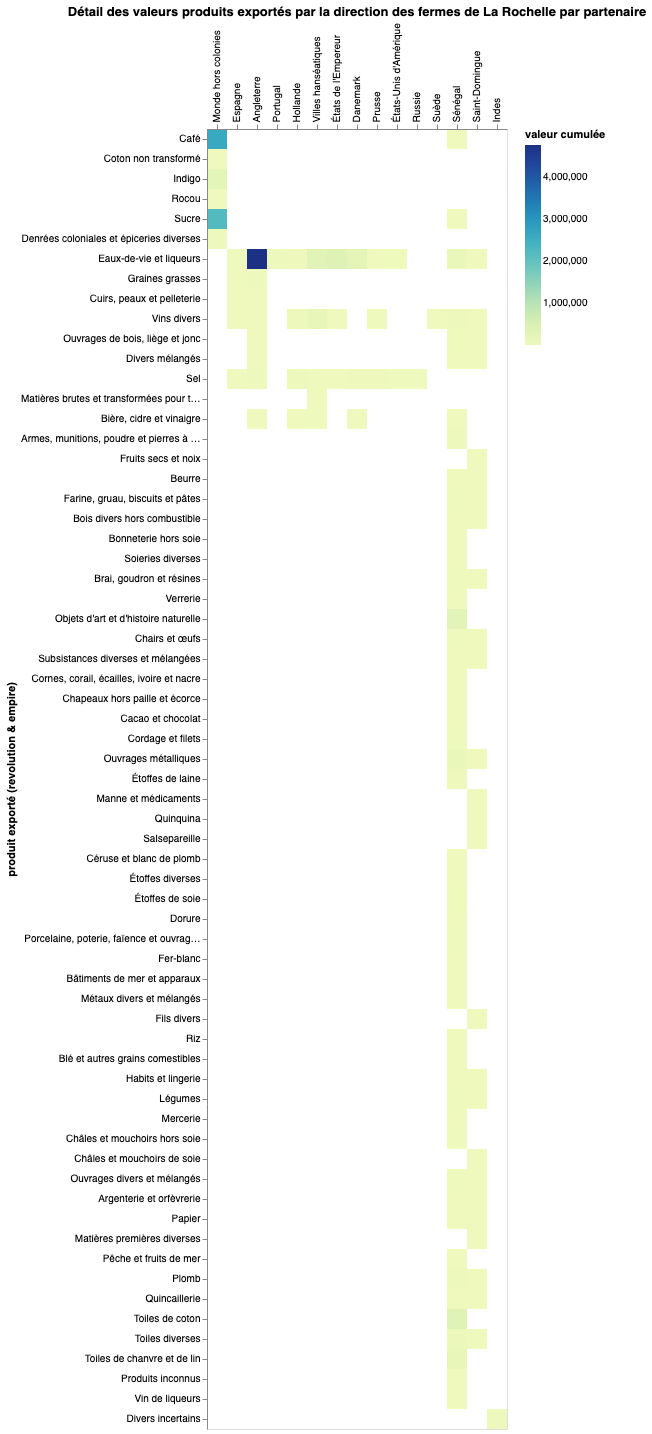

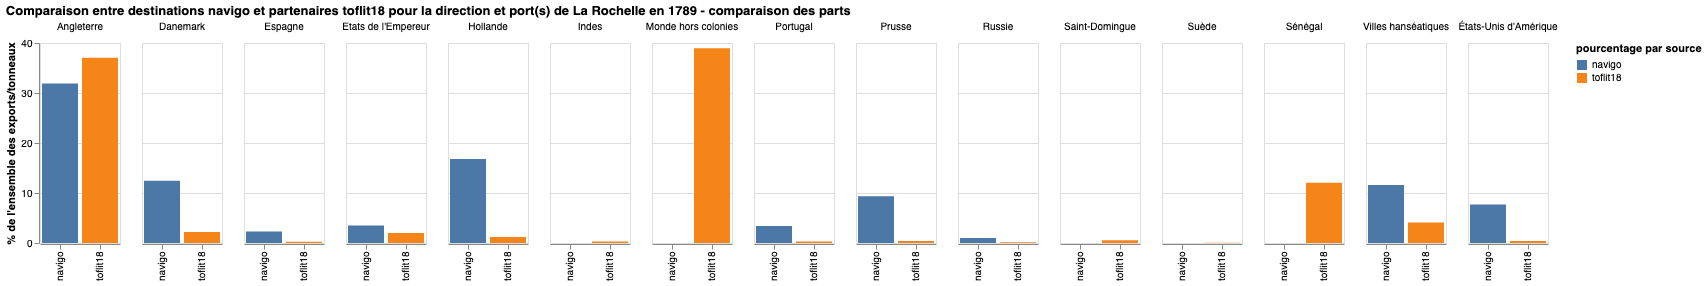

Correspondance résumé : 
                         partner  sum_tonnage   sum_exports  price_per_barrel
0                       Danemark      33049.0  6.334500e+06        191.669945
1                     Angleterre      57563.0  3.420050e+07        594.140333
2                         Russie      14848.0  6.630000e+06        446.524784
3                        Espagne      59250.0  3.283826e+07        554.232315
4                       Hollande      78214.0  3.357150e+07        429.226225
5                       Portugal      14007.0  3.935200e+06        280.945242
6            Villes hanséatiques      68277.0  6.019470e+07        881.624852
7                          Suède      14161.0  5.053700e+06        356.874515
8          États-Unis d'Amérique      22271.0  2.050600e+06         92.074896
9                      Allemagne      28703.0  2.246440e+07        782.649897
10                        Prusse      20644.0  9.008500e+06        436.373765
11          Royaume de Sardaigne      1

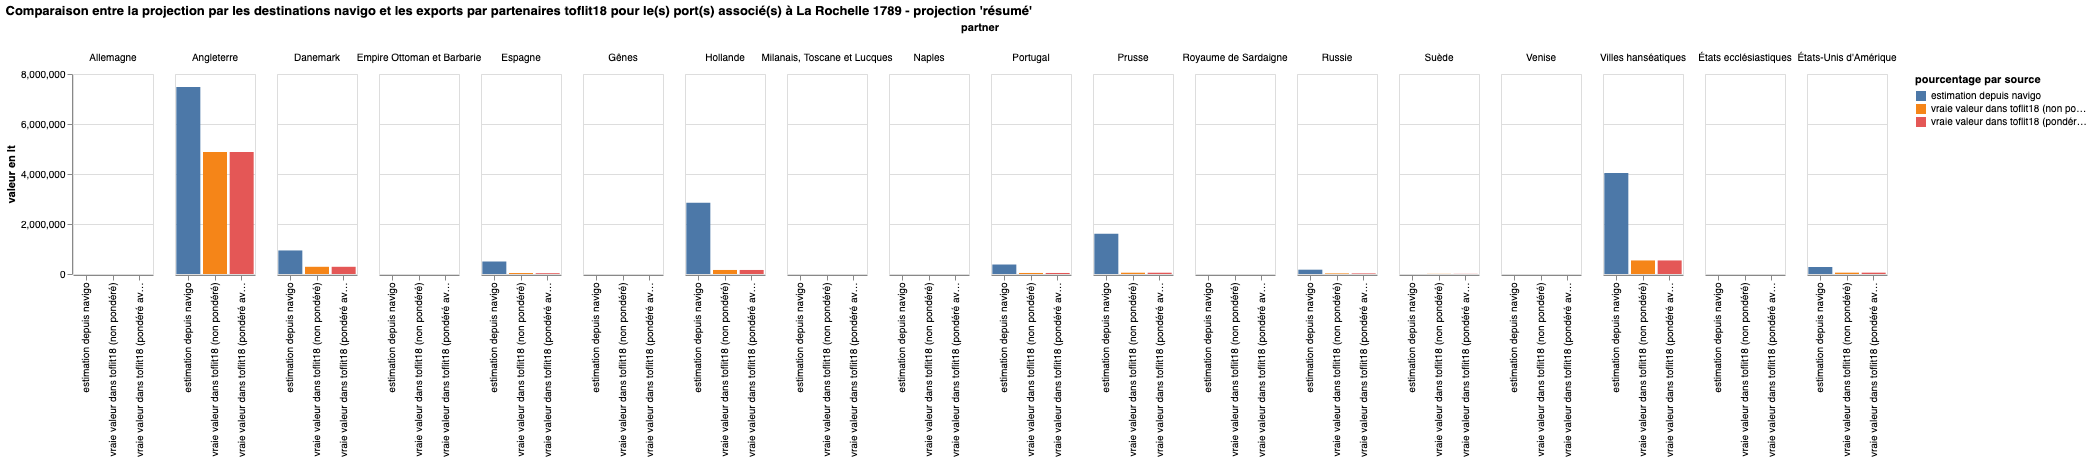

Total des exports en lt selon la projection 'résumé' : 18,258,829 lt
Total des exports en lt selon toflit18 : 13,334,295 lt
Total des exports en lt selon toflit18 (corrigé avec ratios terre-mer) : 13,183,366 lt
Méthode 'résumé' - rapport projection/réalité : facteur de 1.3849899690270715


In [23]:
project_for_bureau('La Rochelle', ferme_key='departure_ferme_direction')

Première analyse : à l'échelle de la direction des fermes, les résultats sont assez proches de la réalité décrite par toflit18 : ils sont surestimés de 38%.

## 4.4. Bilan des tests sur la projection

La projection fonctionne de manière inégale suivant les corpus sur lesquels elle est testée.

Des spécificités font-elles que la projection fonctionne mieux sur certaines zones que d'autres ?

Malgré le caractère décevant et incertain de ces tests, on va néanmoins tenter de projeter le modèle sur le cas de Dunkerque en 1789.

# 5. projection sur Dunkerque 1789

On va maintenant projeter les prix par tonneau/partenaire sur les tonnages partis de Dunkerque, puis les comparer aux données toflit18 partielles dont on dispose sur le commerce colonial.

Pour le cas particulier de l'Angleterre, on va supprimer les bateaux de 12 tonneaux afin de ne pas compter les smoggleurs, pour lesquels on dispose par ailleurs d'estimations plus fiables.

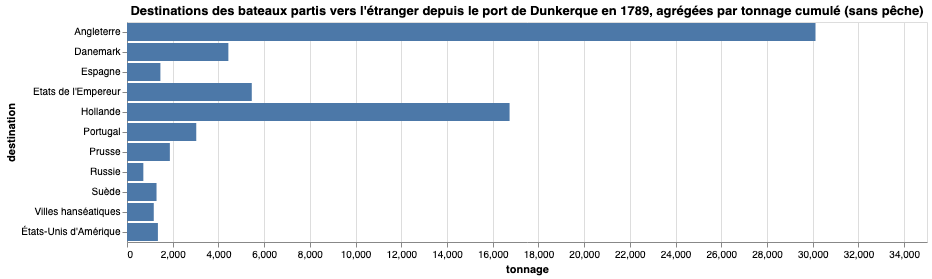

tonnage cumulé 67650.0
nombre de trajets :  837
nombre de trajets vers l'angleterre par smoggleurs :  1144


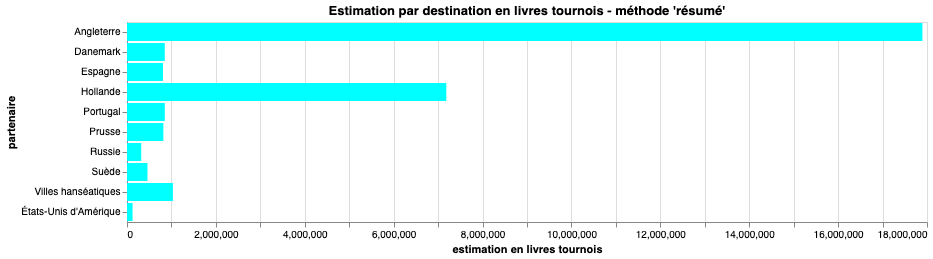

valeur d'export vers l'étranger estimée pour Dunkerque selon la méthode 'résumé' : 30,347,553 livres tournois


In [24]:
# build two models
correspondance_resume, national_ratios = compute_price_per_barrel_per_destination(method='résumé')
# =================================================
# =================================================
# select flows from navigo 1789 - port = 'Dunkerque'
# =================================================
# =================================================


destinations_navigo = {}
sum_tonnage = 0
nb_trajets = 0
nb_trajets_angleterre = 0
with open('../../../data/navigo_all_flows_1789.csv', newline='') as csvfile:
  transformation_map = {
      'Quatre villes hanséatiques': 'Villes hanséatiques',
      'Etats-Unis': 'États-Unis d\'Amérique',
      # 'Etats de l\'Empereur':''
  }
  flows = csv.DictReader(csvfile)
    
  commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
  stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
    
  commodity_id_fields = ['commodity_id', 'commodity_id2', 'commodity_id3', 'commodity_id4']
  fishing_commodities_ids = set(['00000012','00000240','00000240','00000280','00000306','00000307','00000328','00000329','00000331','00000332','00000336',])
    
    
  # stop_commodities = set()
  total_commodities = set()
  for flow in flows:
    destination = flow['destination_partner_balance_1789']
    departure = flow['departure']
#    departure = flow['departure_state_1789_fr']
    if destination in transformation_map:
      destination = transformation_map[destination]
    tonnage = float(flow['tonnage'] or 0)
    if flow['departure_function'] == 'O' \
      and departure == 'Dunkerque' \
      and destination != '' \
      and destination != 'France' \
      and flow['destination_state_1789_fr'] != 'France' :
      if flow['destination_state_1789_fr'] == 'Grande-Bretagne' and tonnage == 12:
        nb_trajets_angleterre += 1
        continue
      commodities = [flow[field].lower() for field in commodity_fields if flow[field] != '']
      not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
      peche_ids = [commodity for commodity in commodities_ids if commodity in fishing_commodities_ids]
      # take the flow if no commodity specified or at least one 'not stop' commodity speciied
      if len(commodities) == 0 or (len(not_stop) > 0 and len(peche_ids) == 0):
        for c in not_stop:
          total_commodities.add(c)
        # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
        # at this point we have all the flows we want
        if destination not in destinations_navigo:
          destinations_navigo[destination] = 0
        destinations_navigo[destination] += tonnage
        sum_tonnage += tonnage
        nb_trajets += 1

VegaLite({
    "title": "Destinations des bateaux partis vers l'étranger depuis le port de Dunkerque en 1789, agrégées par tonnage cumulé (sans pêche)",
    "data": {
        "values": [{"destination": destination, "tonnage": tonnage} for destination, tonnage in destinations_navigo.items()]
    },
    "width": 800,
    "mark": {"type": "bar", "tooltip": True},
      "encoding": {
        "y": {
            "field": "destination", 
            "type": "nominal",
            "title": "destination"
        },
        "x": {
            "field": "tonnage",
            "type": "quantitative"
        }
      }
})

print('tonnage cumulé', sum_tonnage)
print('nombre de trajets : ', nb_trajets)
print('nombre de trajets vers l\'angleterre par smoggleurs : ', nb_trajets_angleterre)

sum_estimates_resume = 0
estimates_resume = []
for cor in correspondance_resume:
    partner = cor['partner']
    if partner in destinations_navigo:
        tonnage = destinations_navigo[partner]
        estimates_resume.append({
            "partenaire": partner,
            "tonnage": tonnage,
            "estimate": tonnage * cor['price_per_barrel']
        })
        sum_estimates_resume += tonnage * cor['price_per_barrel']
VegaLite({
    "title": "Estimation par destination en livres tournois - méthode 'résumé'",
    "data": {
        "values": estimates_resume
    },
    "width": 800,
    "mark": {"type": "bar", "tooltip": True},
      "encoding": {
        "y": {
            "field": "partenaire", 
            "type": "nominal",
            "title": "partenaire"
        },
        "x": {
            "field": "estimate",
            "title": "estimation en livres tournois",
            "type": "quantitative"
        },
          "color": {
              "value": "aqua"
          }
      }
})
print("valeur d'export vers l'étranger estimée pour Dunkerque selon la méthode 'résumé' : " + f'{int(sum_estimates_resume):,}' + " livres tournois")

On estime donc la valeur d'export de Dunkerque à 30 milions de lt (plus les 3.3 milions de LT de smoggleurs).

La projection donne logiquement une place très importante à l'Angleterre. Vient ensuite la Hollande, qui prend une part plus importante des exports en raison d'un prix par tonneau élevé.

Les autres destinations des navires partis de Dunkerque sont plus ou moins "égalisées" par le jeu des prix par tonneaux, notamment le Danemark, le Portugal, la Prusse et les États-Unis qui voient leur part d'exports réduite par rapport à leur part de navigation.

On compare maintenant les projections obtenues aux exports connus par toflit18, qui correspondent aux exports de produits coloniaux et aux exports vers les colonies.

In [25]:
# comparison with real data from Dunkerque exports according to toflit18
destinations_navigo = {}
with open('../../../data/navigo_all_flows_1789.csv', newline='') as csvfile:
  transformation_map = {
      'Quatre villes hanséatiques': 'Villes hanséatiques',
      'Etats-Unis': 'États-Unis d\'Amérique',
      # 'Etats de l\'Empereur':''
  }
  flows = csv.DictReader(csvfile)
  commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
  stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
  total_commodities = set()
  for flow in flows:
    destination = flow['destination_partner_balance_1789']
    departure = flow['departure']
#    departure = flow['departure_state_1789_fr']
    if destination in transformation_map:
      destination = transformation_map[destination]
    tonnage = float(flow['tonnage'] or 0)
    if flow['departure_function'] == 'O' \
      and departure == 'Dunkerque' \
      and destination != '' \
      and destination != 'France' \
      and flow['destination_state_1789_fr'] != 'France' :
      commodities = [flow[field].lower() for field in commodity_fields if flow[field] != '']
      not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
      # take the flow if no commodity specified or at least one 'not stop' commodity speciied
      if len(commodities) == 0 or len(not_stop) > 0:
        for c in not_stop:
          total_commodities.add(c)
        # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
        # at this point we have all the flows we want
        if destination not in destinations_navigo:
          destinations_navigo[destination] = 0
        destinations_navigo[destination] += tonnage
        
exports_toflit18 = {}
imports_toflit18 = {}
with open('../../../data/toflit18_all_flows.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  # and flow['customs_office'].lower().find('dunkerque') != -1 \
  for flow in flows:
    if flow['year'] == '1789' \
      and flow['export_import'] == 'Exports' \
      and flow['customs_office'] == "Dunkerque" \
      and flow['partner_grouping'] != 'France':

      partner = flow['partner_simplification']
      value = float(flow['value'] or 0)
      if partner not in exports_toflit18:
        exports_toflit18[partner] = 0
      exports_toflit18[partner] += value
    #   and flow['partner_grouping'] != 'France':
    if flow['year'] == '1789' \
      and flow['export_import'] == 'Imports' \
      and flow['customs_office'] == "Dunkerque":

      partner = flow['partner_simplification']
      value = float(flow['value'] or 0)
      if partner not in imports_toflit18:
        imports_toflit18[partner] = 0
      imports_toflit18[partner] += value
print('exports : ')
print(pds.DataFrame([{"partenaire": partenaire, "valeur": valeur} for partenaire, valeur in exports_toflit18.items()]))
print('imports hors France : ')
print(pds.DataFrame([{"partenaire": partenaire, "valeur": valeur} for partenaire, valeur in imports_toflit18.items()]))

exports : 
            partenaire     valeur
0  Monde hors colonies  4560525.0
1       Saint-Domingue   388838.0
2               Tobago   373782.0
3           Martinique   573101.0
4           Guadeloupe    29245.0
5    Guinée et Sénégal    46162.0
6    Cayenne et Guyane      375.0
imports hors France : 
                       partenaire      valeur
0             Villes hanséatiques   1467759.0
1                        Hollande   7196299.0
2                      Angleterre  14937716.0
3             États de l'Empereur   4022285.0
4   Îles françaises de l'Amérique   8670155.0
5             Milanais et Toscane    254665.0
6           États-Unis d'Amérique   1479188.0
7                          Prusse   1308952.0
8             Danemark et Norvège    162839.0
9                         Espagne   1767338.0
10                         Russie    238265.0
11                          Suède    699910.0
12                       Portugal     53067.0
13                          Gênes    493638.0
14  

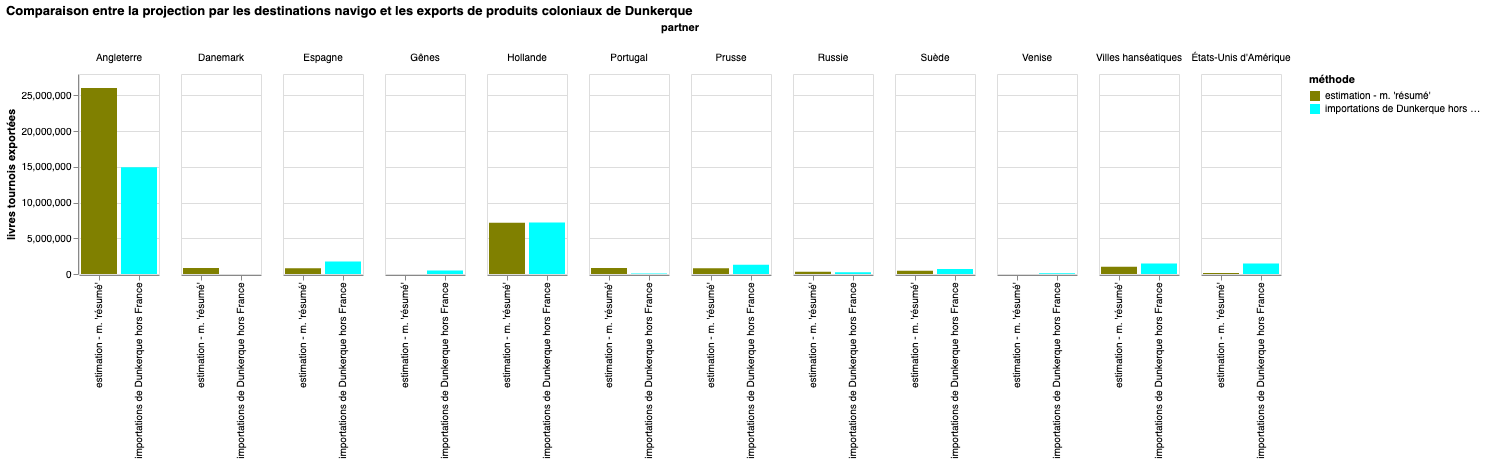

In [26]:

comparaison = []

for cor in correspondance_resume:
    partner = cor['partner']
    if partner in destinations_navigo:
        tonnage = destinations_navigo[partner]
        comparaison.append({
            "partner": partner,
            "group": "estimation - m. 'résumé'",
            "value": tonnage * cor['price_per_barrel']
        })
    if partner in exports_toflit18:
      comparaison.append({
          "partner": partner,
          "group": "exports selon toflit18",
          "value": exports_toflit18[partner]
      })
    if partner in imports_toflit18:
      comparaison.append({
          "partner": partner,
          "group": "importations de Dunkerque hors France",
          "value": imports_toflit18[partner]
      })

VegaLite({
  "title": "Comparaison entre la projection par les destinations navigo et les exports de produits coloniaux de Dunkerque",
  "data": {
      "values": comparaison
  },
  "width": 80,
  "mark": {"type": "bar", "tooltip": True},
    "encoding": {
      "column": {"field": "partner"},
      "y": {
          "field": "value", 
          "type": "quantitative",
          "title": "livres tournois exportées"
      },
      "x": {
          "field": "group",
          "axis": {"title": ""}
      },
      "color": {
          "field": "group",
          "title": "méthode",
          "scale": {
              "range": ["olive", "aqua", "#4c78a8",]
          }
      }
    }
})

somme imports Dunkerque : 42,931,940 lt
somme imports français depuis Dunkerque : 4,095,464 lt
somme exports coloniaux : 5,972,028 lt
somme exports selon la projection résumé : 38,503,911 lt


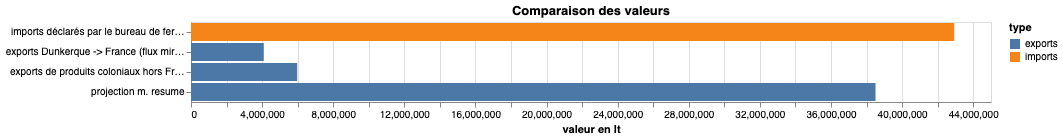

In [27]:
sum_miroir = 0
with open('../../../data/toflit18_all_flows.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  # and flow['customs_office'].lower().find('dunkerque') != -1 \
  for flow in flows:
    if flow['year'] == '1789' \
      and flow['export_import'] != 'Imports'  \
      and flow['partner_simplification'] == 'Dunkerque':
      value = float(flow['value'] or 0)
      sum_miroir += value



sum_projection_resume = 0
for c in comparaison:
    if c['group'] == "estimation - m. 'résumé'":
        sum_projection_resume += c['value']
        
sum_exports = 0
for f, value in exports_toflit18.items():
    sum_exports += value
    
sum_imports = 0
for f, value in imports_toflit18.items():
    sum_imports += value

print('somme imports Dunkerque : ' + f'{int(sum_imports):,}' + ' lt')   
print('somme imports français depuis Dunkerque : ' + f'{int(sum_miroir):,}' + ' lt')
print('somme exports coloniaux : ' + f'{int(sum_exports):,}' + ' lt')
print('somme exports selon la projection résumé : ' + f'{int(sum_projection_resume):,}' + ' lt')

redux = [
{
    "label": "imports déclarés par le bureau de fermes de Dunkerque",
    "type": "imports",
    "valeur": sum_imports
},
{
    "label": "exports Dunkerque -> France (flux miroirs)",
    "type": "exports",
    "valeur": sum_miroir
},
{
    "label": "exports de produits coloniaux hors France (bureau de fermes de Dunkerque)",
    "type": "exports",
    "valeur": sum_exports
},
{
    "label": "projection m. resume",
    "type": "exports",
    "valeur": sum_projection_resume
}, 
]
VegaLite({
  "title": "Comparaison des valeurs",
  "data": {
      "values": redux
  },
  "width": 800,
  "mark": {"type": "bar", "tooltip": True},
    "encoding": {
      "y": {
          "field": "label", 
          "type": "nominal",
          "axis": {"title": ""},
          "sort": "-color"
      },
        "color": {
            "field": "type"
        },
      "x": {
          "field": "valeur",
          "type": "quantitative",
          "title": "valeur en lt"
      }
    }
})

Première analyse : la projection est largement supérieure aux imports déclarés de Dunkerque, ainsi qu'à la somme des exports connus vers le monde (de produits coloniaux) et vers la France (flux miroirs).

# Conclusion


Pour rappel, la méthode a consisté à :

* établir un prix par tonneau et par destination, en estimant les valeurs d'export de la France par la mer seule et les flux navigo par tonnage - pour l'année 1787
* pour les tests : d'une part sommer les flux toflit18 et les pondérer par destination en fonction des ratio terre-mer tels que décrits en 1787, d'autre part sommer les flux navigo par destination en tonnage cumulé puis les transformer en valeur via l'index des prix par tonneau par destination
* pour Dunkerque : sommer les flux navigo par destination en tonnage cumulé puis les transformer en valeur via l'index des prix par tonneau par destination

La méthode trouvée empiriquement pour calculer les prix de tonneau par partenaire semble assez fiable sur l'ensemble de la DF de La Rochelle, mais pas du tout sur d'autres corpora de test.